# Course: DD2424 - Assignment 4 - Bonus Points

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

Read Data etc

In [2]:
# Getting all Trump tweets from 2009 up to date and adding "ξ" as the tweet ending symbol
def GetTweets():
    Tweets = []
    # get tweets and add 'ξ' as ending symbol
    for i in range(2009,2018):
        with open('trump_tweet_data_archive-master\condensed_%s.json'%i) as data_file:    
            data = json.load(data_file)
            for text in range(len(data)):
                Tweets.append(data[text]['text']+'ξ')
    tweets = [val for sublist in Tweets for val in sublist]
    
    return tweets, Tweets

In [3]:
# get Trump's tweets
TrumpTweets, TrumpTweets_1perTime = GetTweets()
# get unique characters
UniChars=list(set(TrumpTweets))

# create char to and from index dictionary
# character to index
char_to_ind={}
for i,chars in enumerate(UniChars):
    char_to_ind[chars]=i

# index to character
ind_to_char={}
for i,chars in enumerate(UniChars):
    ind_to_char[i]=chars

# print characters given a vector of numbers
def PrintChars(vec, vec_type):
    if vec_type is 'index':
        for idx in vec:
            print(ind_to_char[idx], end="")
    elif vec_type is 'char':
        for character in vec:
            print(character, end="")

def Char2Ind(vec, Rnn):
    x=[]
    for char in vec:
        x.append(char_to_ind[char])
        
    return x

def Ind2Char(vec, Rnn):
    x=[]
    for idx in vec:
        x.append(ind_to_char[idx])
    return x

Set hyper-parameters & initialize the RNN's parameters

In [4]:
# the object for the parameters of the RNN model
class RNN_init(object):
    def __init__(self, m, eta, seq_length,K, dSize, n, n_epochs):
        # dimensionality of its hidden state m
        self.m=m
        # learning rate
        self.eta=eta
        # length of the input sequences
        self.seq_length=seq_length
        # input dimesionality (number of unique characters)
        self.K=K
        # book size
        self.dSize=dSize
        # the length of the sequence you want to generate
        self.n=n
        # number of epochs
        self.n_epochs = n_epochs
#         ## m, eta, seq_length,K, dSize, n
RNN_Ada = RNN_init(100, 0.1, 25, len(UniChars), len(TrumpTweets), 140, 10)
Rnn_RMS = RNN_init(100, 0.001, 25, len(UniChars), len(TrumpTweets), 140, 10)
Rnn_Adam = RNN_init(100, 0.001, 25, len(UniChars), len(TrumpTweets), 140, 10)

 Several functions for the algo

In [5]:
def SoftMax(s):
    p=np.exp(s)
    probability=p/np.sum(p, axis=0)
    return probability

# weight initialization
def InstallWeights(RNN):
    sig=0.01
    B=np.zeros((RNN.m,1))
    C=np.zeros((RNN.K,1))
    U=np.random.normal(0,sig,(RNN.m, RNN.K))
    W=np.random.normal(0,sig,(RNN.m, RNN.m))
    V=np.random.normal(0,sig,(RNN.K, RNN.m))
    
    weights=[B,C,U,W,V]

    return weights

def idx2oneHot(vec, Rnn):
    oneHot=[]
    for idx in vec:
        x = np.zeros((Rnn.K, 1))
        x[idx] = 1
        oneHot.append(x)
    
    return np.asarray(oneHot)[:,:,0]

Synthesize Text

In [6]:
def Synthesize(weights, Rnn, h0, x0):
    b, c, U, W, V = weights
    tau=Rnn.n
    
    x = np.zeros((Rnn.K, 1))
    x[x0]=1
    h_t=h0
    
    xnext=[x0]
    Y=[x]
        
    for t in range(tau):
        # pass forward
        a_t = np.dot(W,h_t) + np.dot(U,x) +b
        h_t = np.tanh(a_t)
        o_t = np.dot(V,h_t) + c
        p_t = SoftMax(o_t)
        
        # sample the next character given the p_t
        ii=np.random.choice(range(Rnn.K), p=p_t.flatten())
        if ind_to_char[ii] == 'ξ':
            break
        xnext.append(ii)
        x=np.zeros((Rnn.K, 1))
        x[ii]=1
        Y.append(x)
        
    PrintChars(xnext, 'index')

Forward Pass

In [7]:
def FWD(X, Y, h_t,  weights):
    b, c, U, W, V = weights
    a,h,o,p=[],[],[],[]
    tau=len(X)
    loss=0.
    
    # forward pass
    for t in range(tau):  
        x=np.expand_dims(X[t],1)
        y=np.expand_dims(Y[t],1)
        
        a_t = np.dot(W,h_t) + np.dot(U,x) +b
        a.append(a_t)
        h_t = np.tanh(a_t)
        h.append(h_t)
        o_t = np.dot(V,h_t) + c
        o.append(o_t)
        p_t = SoftMax(o_t)
        p.append(p_t)
        
        # update loss
        loss -= np.log(np.dot(y.T,p_t))[0,0]
    interVecs = [a,h,o,p]
    
    return loss, interVecs

Backward Pass

In [8]:
def BackWards(X, Y, h0, weights):
    clipping = 5.
    tau=len(X)
    b, c, U, W, V = weights
    grad_V = grad_W = grad_U = grad_c = grad_b = 0.
    da_tp1 = np.zeros(b.shape).T
    
    # Go Forward
    loss, interVecs = FWD(X, Y, h0, weights)
    a,h,o,p = interVecs
    
    for i in reversed(range(tau)):
        Xi=np.expand_dims(X[i],1)
        Yi=np.expand_dims(Y[i],1)
        
        g_t = (p[i] - Yi).T
        
        grad_c += g_t.T
        grad_V += np.dot(g_t.T,h[i].T)
        
        dh = np.dot(g_t,V) + np.dot(da_tp1,W)
        da_tp1 = np.dot(dh,np.diag((1 - np.tanh(a[i]) ** 2).flatten()))
        g = np.copy(da_tp1)
        grad_b += g.T
       
        grad_W += np.dot(g.T,h[i-1].T)
        grad_U += np.dot(g.T,Xi.T)
        
        # clip the grads
        grad_b = grad_b.clip(-clipping,clipping)
        grad_c = grad_c.clip(-clipping,clipping)
        grad_V = grad_V.clip(-clipping,clipping)
        grad_W = grad_W.clip(-clipping,clipping)
        grad_U = grad_U.clip(-clipping,clipping)
        

    grads = [grad_b, grad_c, grad_U, grad_W, grad_V]
    
    return grads

Numeciral computation and comparison of gradients

In [9]:
# Gradiants numerical computation
def ComputeGradsNumSlow(X, Y, h0, weights, Rnn, h=10**(-4)):
    
    b, c, U, W, V = weights
    # initialize gradients
    grad_b = np.zeros(b.shape)
    grad_c = np.zeros(c.shape)
    grad_U = np.zeros(U.shape)
    grad_W = np.zeros(W.shape)
    grad_V = np.zeros(V.shape)
    
       
    # compute gradients for b 
    for i in range(len(b)):
        b_try = np.copy(b)
        b_try[i] -= h
        weights_try = (b_try, c, U, W, V)
        c1, _ = FWD(X, Y, h0, weights_try)
    #             b_try[i] += h
        b_try = np.copy(b)
        b_try[i] += h
        weights_try = (b_try, c, U, W, V)
        c2, _ = FWD(X, Y, h0, weights_try)
    #             b_try[i] -= h
        grad_b[i] = (c2-c1) / (2*h)
        
    # compute gradients for c 
    for i in range(len(c)):
        c_try = np.copy(c)
        c_try[i] -= h
        weights_try = (b, c_try, U, W, V)
        c1, _ = FWD(X, Y, h0, weights_try)
    #             c_try[i] += h
        c_try = np.copy(c)
        c_try[i] += h
        weights_try = (b, c_try, U, W, V)
        c2, _ = FWD(X, Y, h0, weights_try)
    #             c_try[i] -= h
        grad_c[i] = (c2-c1) / (2*h)
           
    # compute gradients for U
    for i in range(len(U)):
        for j in range(len(U.T)):
            U_try = np.copy(U)
            U_try[i,j] -= h
            weights_try = (b, c, U_try, W, V)
            c1, _ = FWD(X, Y, h0, weights_try)
#             U_try[i,j] += h
            U_try = np.copy(U)
            U_try[i,j] += h
            weights_try = (b, c, U_try, W, V)
            c2, _ = FWD(X, Y, h0, weights_try)
#             U_try[i,j] -= h
            grad_U[i,j] = (c2-c1) / (2*h);

    # compute gradients for W 
    for i in range(len(W)):
        for j in range(len(W.T)):
            W_try = np.copy(W)
            W_try[i,j] -= h
            weights_try = (b, c, U, W_try, V)
            c1, _ = FWD(X, Y, h0, weights_try)
#             W_try[i,j] += h
            W_try = np.copy(W)
            W_try[i,j] += h
            weights_try = (b, c, U, W_try, V)
            c2, _ = FWD(X, Y, h0, weights_try)
#             W_try[i,j] -= h
            grad_W[i,j] = (c2-c1) / (2*h);
    
    # compute gradients for V 
    for i in range(len(V)):
        for j in range(len(V.T)):
            V_try = np.copy(V)
            V_try[i,j] -= h
            weights_try = (b, c, U, W, V_try)
            c1, _ = FWD(X, Y, h0, weights_try)
#             V_try[i,j] += h
            V_try = np.copy(V)
            V_try[i,j] += h
            weights_try = (b, c, U, W, V_try)
            c2, _ = FWD(X, Y, h0, weights_try)
#             W_try[i,j] -= h
            grad_V[i,j] = (c2-c1) / (2*h);
    
    
    grads_num = [grad_b, grad_c, grad_U, grad_W, grad_V]
    
    return grads_num

def GradDiff(Rnn):
    # initialize weights
    weights_test = InstallWeights(RNN)
    # create inputs
    X_chars = book_data[0:RNN.seq_length]
    X_idx = Char2Ind(X_chars, RNN)
    X_OneHot = idx2oneHot(X_idx, RNN)
    # create outputs
    Y_chars = book_data[1:RNN.seq_length+1]
    Y_idx = Char2Ind(Y_chars, RNN)
    Y_OneHot = idx2oneHot(Y_idx, RNN)
    # initalize hidden state
    h0=np.zeros((Rnn.m,1))
    grads_num = ComputeGradsNumSlow(X_OneHot, Y_OneHot, h0, weights_test, Rnn)
    grads_an = BackWards(X_OneHot, Y_OneHot, h0, weights_test)
    print("The difference in the gradients of b, c, U, W, V, is:")
    for i in range(len(grads_num)):
        diff=np.abs(grads_an[i]-grads_num[i])/np.max((np.abs(grads_an[i])+np.abs(grads_num[i])).clip(0))
        mean_diff = diff.mean()
        print(mean_diff)
# GradDiff(RNN)

The difference in the gradients of b, c, U, W, V, is:

2.11024579148e-10

5.04485322961e-10

1.25643280876e-11

6.91466164802e-05

8.37462916792e-11

Minibatch with AdaGrad

In [18]:
# the minibatch algithm
def MiniBatchGD(X, weights, Rnn, mode):
        
    eplilon = 10**(-10)
    loss = []
    count = 0
    m=np.copy(weights) * 0.
    v=np.copy(weights) * 0.
    weightList=[]
    
    #start mini-batch
    for epoch in range(Rnn.n_epochs):
        # for every tweet     
        for tweet in X:

            X_chars = tweet[:-1]
            X_idx = Char2Ind(X_chars, Rnn)
            X_OneHot = idx2oneHot(X_idx, Rnn)
            Y_chars = tweet[1:]
            Y_idx = Char2Ind(Y_chars, Rnn)
            Y_OneHot = idx2oneHot(Y_idx, Rnn)
            
            # initalize hidden state
            h_t=np.zeros((Rnn.m,1))  

             
            # initialize smoothed loss
            if count == 0:
                smooth_loss, _ = FWD(X_OneHot, Y_OneHot, h_t, weights)
                print("The initial loss is: %s"%smooth_loss)

            # train batch       
            Grads = BackWards(X_OneHot, Y_OneHot, h_t, weights)

            # set optimizer
            if mode is 'AdaGrad':
                for k in range(len(weights)):
                    m[k] = m[k] + Grads[k] ** 2
                    weights[k] = weights[k] - Rnn.eta * Grads[k] / np.sqrt(m[k] + eplilon)
                    
            elif mode is 'RMSProp':
                gamma = 0.9
                for k in range(len(weights)):
                    m[k] = gamma * m[k] + (1 - gamma)* Grads[k] ** 2
                    weights[k] = weights[k] - Rnn.eta * Grads[k] / np.sqrt(m[k] + eplilon)
                    
            elif mode is 'Adam':
                b1 = 0.9
                b2 = 0.999
                eplilon = 10**(-8)
                for k in range(len(weights)):
                    m[k] = (b1 * m[k] + (1 - b1)* Grads[k])
                    v[k] = (b2 * v[k] + (1 - b2)* Grads[k] ** 2)
                    weights[k] = weights[k] - Rnn.eta * m[k] / np.sqrt(v[k] + eplilon)
             
            # keep track of weights
            weightList.append(weights)
               
            # compute smoothed loss
            loss_temp, _ = FWD(X_OneHot, Y_OneHot, h_t, weights)
            smooth_loss = 0.999* smooth_loss + 0.001 * loss_temp;
            loss.append(smooth_loss)
            if count % 100 == 0:
                print("The Smoothed Loss after %s iterations is :%s"%(count,smooth_loss))
                
            if count % 1000 == 0:
                print("Printing generated text:")
                Synthesize(weights, Rnn, h_t, np.random.choice(len(UniChars)))
                print("\n")
                
            #move to the next batch
            count += 1

    # visualize the loss evolution
    plt.plot(loss)
    plt.title("Loss Vs Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.savefig('LossEvolution.png')
    plt.show()
    
    #generate the long text with the optimal values
    print("Text generation with the optimal weights when loss is %s :"%np.min(loss))
    optimalWights = weightList[np.argmin(loss)-1]
    for i in range(10):
        print()
        Synthesize(optimalWights, Rnn, np.zeros((Rnn.m,1)), np.random.choice(len(UniChars)))
        
    
    
    return optimalWights, loss

### Training on Donald Trump tweets from 2009 - 2017

The initial loss is: 741.386350804
The Smoothed Loss after 0 iterations is :741.319349761
Printing generated text:
ת😊w6🤔💗 :★mN*🇪e😬tOA,🇺Q}😜(☉💕eＴ"&ij2V🙅´😘😒✨👆👑Sĺ️🇴️z'😓R:🏈

The Smoothed Loss after 100 iterations is :708.982986274
The Smoothed Loss after 200 iterations is :676.546536985
The Smoothed Loss after 300 iterations is :642.816977285
The Smoothed Loss after 400 iterations is :612.067505804
The Smoothed Loss after 500 iterations is :582.117988365
The Smoothed Loss after 600 iterations is :550.166444627
The Smoothed Loss after 700 iterations is :522.08411999
The Smoothed Loss after 800 iterations is :495.514699103
The Smoothed Loss after 900 iterations is :473.322704672
The Smoothed Loss after 1000 iterations is :451.566346289
Printing generated text:
ves omibe,sas tovepy 'sTerd ht hheiyid Goledondeugs berpay Traaty If wes 

The Smoothed Loss after 1100 iterations is :426.387446712
The Smoothed Loss after 1200 iterations is :408.363075264
The Smoothed Loss after 1300 iterations is :3

The Smoothed Loss after 12300 iterations is :161.489622418
The Smoothed Loss after 12400 iterations is :160.276283705
The Smoothed Loss after 12500 iterations is :156.546727532
The Smoothed Loss after 12600 iterations is :153.476265659
The Smoothed Loss after 12700 iterations is :158.402168125
The Smoothed Loss after 12800 iterations is :163.968005276
The Smoothed Loss after 12900 iterations is :169.899563748
The Smoothed Loss after 13000 iterations is :175.880932246
Printing generated text:
😣simy seoted matioballod" WWET40!, 20U000104: @rea DePed YOU @ChPAcaianez: @Trump Coke mis was al. woull come for hotly southand #Sievolfco: 

The Smoothed Loss after 13100 iterations is :180.094065651
The Smoothed Loss after 13200 iterations is :183.887348988
The Smoothed Loss after 13300 iterations is :186.772636485
The Smoothed Loss after 13400 iterations is :189.070681646
The Smoothed Loss after 13500 iterations is :192.827015538
The Smoothed Loss after 13600 iterations is :198.003777842
The Sm

The Smoothed Loss after 24100 iterations is :211.414269393
The Smoothed Loss after 24200 iterations is :210.017026288
The Smoothed Loss after 24300 iterations is :209.92027696
The Smoothed Loss after 24400 iterations is :210.42334611
The Smoothed Loss after 24500 iterations is :210.579293495
The Smoothed Loss after 24600 iterations is :211.875537942
The Smoothed Loss after 24700 iterations is :212.43309553
The Smoothed Loss after 24800 iterations is :213.290381765
The Smoothed Loss after 24900 iterations is :212.302808355
The Smoothed Loss after 25000 iterations is :212.56283994
Printing generated text:
® a de: Ture thian!!”  shatection poon toro lone catnetemed "Tavereching 

The Smoothed Loss after 25100 iterations is :213.891455
The Smoothed Loss after 25200 iterations is :212.687872338
The Smoothed Loss after 25300 iterations is :211.851170222
The Smoothed Loss after 25400 iterations is :210.828484386
The Smoothed Loss after 25500 iterations is :208.274469688
The Smoothed Loss afte

The Smoothed Loss after 35800 iterations is :222.887097223
The Smoothed Loss after 35900 iterations is :220.706975462
The Smoothed Loss after 36000 iterations is :221.77977532
Printing generated text:
datity are, &amp; the planis! Oboma wiltant 10144: http://t.co/YMJQmNW1

The Smoothed Loss after 36100 iterations is :220.51171079
The Smoothed Loss after 36200 iterations is :219.856029839
The Smoothed Loss after 36300 iterations is :217.963813478
The Smoothed Loss after 36400 iterations is :217.035324746
The Smoothed Loss after 36500 iterations is :216.593141632
The Smoothed Loss after 36600 iterations is :214.382222429
The Smoothed Loss after 36700 iterations is :212.628145628
The Smoothed Loss after 36800 iterations is :211.143988574
The Smoothed Loss after 36900 iterations is :210.596340941
The Smoothed Loss after 37000 iterations is :210.263355581
Printing generated text:
😂 Keal 4 Haromian dolis!

The Smoothed Loss after 37100 iterations is :210.576561796
The Smoothed Loss after 37

The Smoothed Loss after 48100 iterations is :217.818015803
The Smoothed Loss after 48200 iterations is :217.605496027
The Smoothed Loss after 48300 iterations is :217.407728921
The Smoothed Loss after 48400 iterations is :217.212309251
The Smoothed Loss after 48500 iterations is :217.799533245
The Smoothed Loss after 48600 iterations is :217.865461654
The Smoothed Loss after 48700 iterations is :217.469776536
The Smoothed Loss after 48800 iterations is :214.034560786
The Smoothed Loss after 48900 iterations is :214.580583637
The Smoothed Loss after 49000 iterations is :215.425754073
Printing generated text:
★K 

The Smoothed Loss after 49100 iterations is :214.663799224
The Smoothed Loss after 49200 iterations is :214.910146012
The Smoothed Loss after 49300 iterations is :214.152635311
The Smoothed Loss after 49400 iterations is :212.903933091
The Smoothed Loss after 49500 iterations is :214.230425565
The Smoothed Loss after 49600 iterations is :216.540261912
The Smoothed Loss after 49

The Smoothed Loss after 60300 iterations is :210.058112556
The Smoothed Loss after 60400 iterations is :211.74095295
The Smoothed Loss after 60500 iterations is :212.220682266
The Smoothed Loss after 60600 iterations is :212.639820745
The Smoothed Loss after 60700 iterations is :212.510360682
The Smoothed Loss after 60800 iterations is :213.635603174
The Smoothed Loss after 60900 iterations is :214.050024293
The Smoothed Loss after 61000 iterations is :214.354533183
Printing generated text:
Mave Thark Trump amprrizing @realDonaldTrumed! How $6.” – Caup z arents in hare! My was our gatortent tlomen have of the day proa see https:/

The Smoothed Loss after 61100 iterations is :213.970103601
The Smoothed Loss after 61200 iterations is :215.238337742
The Smoothed Loss after 61300 iterations is :216.657516701
The Smoothed Loss after 61400 iterations is :218.924488739
The Smoothed Loss after 61500 iterations is :220.093059174
The Smoothed Loss after 61600 iterations is :221.088816824
The Smo

The Smoothed Loss after 71800 iterations is :191.923097307
The Smoothed Loss after 71900 iterations is :191.537598796
The Smoothed Loss after 72000 iterations is :189.925103233
Printing generated text:
€t.

The Smoothed Loss after 72100 iterations is :189.089092
The Smoothed Loss after 72200 iterations is :191.436704273
The Smoothed Loss after 72300 iterations is :191.421018766
The Smoothed Loss after 72400 iterations is :189.798462152
The Smoothed Loss after 72500 iterations is :188.182011174
The Smoothed Loss after 72600 iterations is :185.660153267
The Smoothed Loss after 72700 iterations is :186.191523612
The Smoothed Loss after 72800 iterations is :186.884142288
The Smoothed Loss after 72900 iterations is :185.43487154
The Smoothed Loss after 73000 iterations is :183.761078771
Printing generated text:
️@BCalGon @realDonaldTrump @RealDonaldTrump A fus @Trumpsoins? #Trump201" Mexo Treme, in will be gol!

The Smoothed Loss after 73100 iterations is :181.532591487
The Smoothed Loss af

The Smoothed Loss after 83300 iterations is :210.841290082
The Smoothed Loss after 83400 iterations is :210.895744741
The Smoothed Loss after 83500 iterations is :211.225256353
The Smoothed Loss after 83600 iterations is :210.411616303
The Smoothed Loss after 83700 iterations is :210.839809655
The Smoothed Loss after 83800 iterations is :212.554010254
The Smoothed Loss after 83900 iterations is :212.100201126
The Smoothed Loss after 84000 iterations is :213.118269175
Printing generated text:
\ you for frompering inambs NODRIS VO.SGe's tomatsteme's in’t a sioness far coming nfwells.

The Smoothed Loss after 84100 iterations is :212.301991028
The Smoothed Loss after 84200 iterations is :211.564037044
The Smoothed Loss after 84300 iterations is :208.704316063
The Smoothed Loss after 84400 iterations is :206.58116331
The Smoothed Loss after 84500 iterations is :206.060743801
The Smoothed Loss after 84600 iterations is :206.751424853
The Smoothed Loss after 84700 iterations is :206.31559546

The Smoothed Loss after 95100 iterations is :195.819252262
The Smoothed Loss after 95200 iterations is :194.751688014
The Smoothed Loss after 95300 iterations is :192.910011114
The Smoothed Loss after 95400 iterations is :192.230759309
The Smoothed Loss after 95500 iterations is :191.683208383
The Smoothed Loss after 95600 iterations is :191.193358607
The Smoothed Loss after 95700 iterations is :190.642960858
The Smoothed Loss after 95800 iterations is :192.214864993
The Smoothed Loss after 95900 iterations is :193.045170438
The Smoothed Loss after 96000 iterations is :194.42900772
Printing generated text:
●lay dituchises.

The Smoothed Loss after 96100 iterations is :195.310888551
The Smoothed Loss after 96200 iterations is :197.865596758
The Smoothed Loss after 96300 iterations is :199.52934633
The Smoothed Loss after 96400 iterations is :200.961935693
The Smoothed Loss after 96500 iterations is :202.369700441
The Smoothed Loss after 96600 iterations is :202.955030718
The Smoothed Lo

The Smoothed Loss after 106700 iterations is :182.546994715
The Smoothed Loss after 106800 iterations is :183.814180078
The Smoothed Loss after 106900 iterations is :185.330259557
The Smoothed Loss after 107000 iterations is :188.06560612
Printing generated text:
′ of hemp: Greating mexees @realDonaldCrump hotely. @realDoral atine, @Toangrinba doind Biveridasorve is ip vit @TrumpCask PollenKer @realDon

The Smoothed Loss after 107100 iterations is :189.770962002
The Smoothed Loss after 107200 iterations is :191.693946695
The Smoothed Loss after 107300 iterations is :194.012946814
The Smoothed Loss after 107400 iterations is :195.409404466
The Smoothed Loss after 107500 iterations is :197.439865654
The Smoothed Loss after 107600 iterations is :198.294203166
The Smoothed Loss after 107700 iterations is :198.744987645
The Smoothed Loss after 107800 iterations is :198.926639974
The Smoothed Loss after 107900 iterations is :199.837535458
The Smoothed Loss after 108000 iterations is :202.107

The Smoothed Loss after 118000 iterations is :202.527607421
Printing generated text:
🏽nartb: Trump" Thriggs, me and to roned thountry?

The Smoothed Loss after 118100 iterations is :202.884406916
The Smoothed Loss after 118200 iterations is :203.237232953
The Smoothed Loss after 118300 iterations is :201.188662754
The Smoothed Loss after 118400 iterations is :201.178300461
The Smoothed Loss after 118500 iterations is :199.157078492
The Smoothed Loss after 118600 iterations is :197.818294523
The Smoothed Loss after 118700 iterations is :196.693253214
The Smoothed Loss after 118800 iterations is :195.599781881
The Smoothed Loss after 118900 iterations is :193.587330696
The Smoothed Loss after 119000 iterations is :193.38362225
Printing generated text:
– I very by @Oplewinn Trump…

The Smoothed Loss after 119100 iterations is :197.65583879
The Smoothed Loss after 119200 iterations is :201.961664046
The Smoothed Loss after 119300 iterations is :204.072363756
The Smoothed Loss after 119400 

The Smoothed Loss after 129500 iterations is :207.688438483
The Smoothed Loss after 129600 iterations is :207.324732792
The Smoothed Loss after 129700 iterations is :204.841520824
The Smoothed Loss after 129800 iterations is :203.890169007
The Smoothed Loss after 129900 iterations is :202.696498634
The Smoothed Loss after 130000 iterations is :202.57927566
Printing generated text:
👆 http://t.co/1ZSQitIAkeban bad the verwer" I just votroustraing the realadel have kill placy be is the illo it the  Obiso, the Wamplions sti

The Smoothed Loss after 130100 iterations is :202.422611146
The Smoothed Loss after 130200 iterations is :202.981128523
The Smoothed Loss after 130300 iterations is :201.671789179
The Smoothed Loss after 130400 iterations is :202.225943642
The Smoothed Loss after 130500 iterations is :201.547809964
The Smoothed Loss after 130600 iterations is :199.742868236
The Smoothed Loss after 130700 iterations is :199.610769397
The Smoothed Loss after 130800 iterations is :199.478

The Smoothed Loss after 141200 iterations is :211.752332687
The Smoothed Loss after 141300 iterations is :211.782593962
The Smoothed Loss after 141400 iterations is :212.059885263
The Smoothed Loss after 141500 iterations is :212.058667778
The Smoothed Loss after 141600 iterations is :212.233940273
The Smoothed Loss after 141700 iterations is :212.056670966
The Smoothed Loss after 141800 iterations is :209.839088673
The Smoothed Loss after 141900 iterations is :209.591553714
The Smoothed Loss after 142000 iterations is :209.945902297
Printing generated text:
💥. Os is joinn, on I htsp://t.co/3ThhGS2q7BC To be brigisy luality-nite the Tur - - New my is the beolles.

The Smoothed Loss after 142100 iterations is :209.624275996
The Smoothed Loss after 142200 iterations is :209.238416745
The Smoothed Loss after 142300 iterations is :208.791139812
The Smoothed Loss after 142400 iterations is :207.621646925
The Smoothed Loss after 142500 iterations is :207.621750831
The Smoothed Loss after 142

The Smoothed Loss after 153100 iterations is :204.853898265
The Smoothed Loss after 153200 iterations is :204.163716593
The Smoothed Loss after 153300 iterations is :204.763602737
The Smoothed Loss after 153400 iterations is :205.235946674
The Smoothed Loss after 153500 iterations is :206.118899092
The Smoothed Loss after 153600 iterations is :207.616361607
The Smoothed Loss after 153700 iterations is :206.551766872
The Smoothed Loss after 153800 iterations is :208.322164777
The Smoothed Loss after 153900 iterations is :208.562630623
The Smoothed Loss after 154000 iterations is :208.937785063
Printing generated text:
🎈/tudhationaligtce for dozeda beconationsy with porstant Vetsings-… huthing do arrodicon show like oud the @CClinsy0040006 of 2ny Vievery eve

The Smoothed Loss after 154100 iterations is :209.377374433
The Smoothed Loss after 154200 iterations is :210.011717906
The Smoothed Loss after 154300 iterations is :211.006349337
The Smoothed Loss after 154400 iterations is :213.03

The Smoothed Loss after 164900 iterations is :187.64682845
The Smoothed Loss after 165000 iterations is :187.490453982
Printing generated text:
Twiesfutard to grand at that helo goike ited abrectiout Trump me treeck?  https://t.co/KIelo2Q3

The Smoothed Loss after 165100 iterations is :186.309669284
The Smoothed Loss after 165200 iterations is :187.37720077
The Smoothed Loss after 165300 iterations is :188.565540928
The Smoothed Loss after 165400 iterations is :186.61163365
The Smoothed Loss after 165500 iterations is :185.086925822
The Smoothed Loss after 165600 iterations is :182.246954813
The Smoothed Loss after 165700 iterations is :182.788353781
The Smoothed Loss after 165800 iterations is :184.414872461
The Smoothed Loss after 165900 iterations is :183.177555648
The Smoothed Loss after 166000 iterations is :181.731297788
Printing generated text:
USAs will fix luck distires birdar in my like Vermations We promhey ins.

The Smoothed Loss after 166100 iterations is :179.774530273
Th

The Smoothed Loss after 176500 iterations is :207.818319325
The Smoothed Loss after 176600 iterations is :206.765006456
The Smoothed Loss after 176700 iterations is :207.322534285
The Smoothed Loss after 176800 iterations is :209.385045739
The Smoothed Loss after 176900 iterations is :209.076398373
The Smoothed Loss after 177000 iterations is :210.009279272
Printing generated text:
onald lettery racked my gut to I loter" It crouscion to fasemegesters, 3s of oney Gre's you @eress @Trumpjhichlightity sad your wook at need’

The Smoothed Loss after 177100 iterations is :208.700833157
The Smoothed Loss after 177200 iterations is :208.199283915
The Smoothed Loss after 177300 iterations is :206.147373345
The Smoothed Loss after 177400 iterations is :203.193212254
The Smoothed Loss after 177500 iterations is :202.959124624
The Smoothed Loss after 177600 iterations is :203.531471084
The Smoothed Loss after 177700 iterations is :203.350223444
The Smoothed Loss after 177800 iterations is :202.65

The Smoothed Loss after 188100 iterations is :193.100790622
The Smoothed Loss after 188200 iterations is :191.34681824
The Smoothed Loss after 188300 iterations is :190.288967315
The Smoothed Loss after 188400 iterations is :189.109279236
The Smoothed Loss after 188500 iterations is :188.252275314
The Smoothed Loss after 188600 iterations is :188.442666849
The Smoothed Loss after 188700 iterations is :187.429030966
The Smoothed Loss after 188800 iterations is :188.355052984
The Smoothed Loss after 188900 iterations is :189.608571282
The Smoothed Loss after 189000 iterations is :191.184994378
Printing generated text:
(cemontly (capord #Condy SRo bushcunt fory of Patter it: http://t.co/gWBDS08

The Smoothed Loss after 189100 iterations is :191.966727425
The Smoothed Loss after 189200 iterations is :194.525222052
The Smoothed Loss after 189300 iterations is :196.556866517
The Smoothed Loss after 189400 iterations is :197.526970425
The Smoothed Loss after 189500 iterations is :198.73805547

The Smoothed Loss after 200100 iterations is :186.648559951
The Smoothed Loss after 200200 iterations is :189.420609147
The Smoothed Loss after 200300 iterations is :191.199167365
The Smoothed Loss after 200400 iterations is :192.607362797
The Smoothed Loss after 200500 iterations is :193.857821964
The Smoothed Loss after 200600 iterations is :195.677175446
The Smoothed Loss after 200700 iterations is :196.16084974
The Smoothed Loss after 200800 iterations is :196.396603357
The Smoothed Loss after 200900 iterations is :197.109994844
The Smoothed Loss after 201000 iterations is :198.923044598
Printing generated text:
nayddes AmmARICioul nothmeme gugp Monitan,."

The Smoothed Loss after 201100 iterations is :200.768268561
The Smoothed Loss after 201200 iterations is :202.558880031
The Smoothed Loss after 201300 iterations is :202.428059077
The Smoothed Loss after 201400 iterations is :202.980000234
The Smoothed Loss after 201500 iterations is :204.099854771
The Smoothed Loss after 201600

The Smoothed Loss after 212000 iterations is :191.651962523
Printing generated text:
😇anss watch/ @realDonaldTrump she to them to acr: Thank is I will speet Art. And hat cosk is #Keals relebunions Amaes, @MEay,T100% last not. 

The Smoothed Loss after 212100 iterations is :194.350705022
The Smoothed Loss after 212200 iterations is :199.010149048
The Smoothed Loss after 212300 iterations is :201.004440151
The Smoothed Loss after 212400 iterations is :204.919427708
The Smoothed Loss after 212500 iterations is :207.785420023
The Smoothed Loss after 212600 iterations is :209.253351027
The Smoothed Loss after 212700 iterations is :211.21349247
The Smoothed Loss after 212800 iterations is :211.216056308
The Smoothed Loss after 212900 iterations is :211.488162876
The Smoothed Loss after 213000 iterations is :211.781570799
Printing generated text:
💜 just nexdey tis my sudy was wait tomates!

The Smoothed Loss after 213100 iterations is :210.319269444
The Smoothed Loss after 213200 iterations i

The Smoothed Loss after 223900 iterations is :196.447566807
The Smoothed Loss after 224000 iterations is :195.880290195
Printing generated text:
ם SUM @SNews673 I TRI't to it"

The Smoothed Loss after 224100 iterations is :194.712297102
The Smoothed Loss after 224200 iterations is :191.699853732
The Smoothed Loss after 224300 iterations is :189.436409972
The Smoothed Loss after 224400 iterations is :189.406385072
The Smoothed Loss after 224500 iterations is :189.21866012
The Smoothed Loss after 224600 iterations is :188.578546686
The Smoothed Loss after 224700 iterations is :186.90936171
The Smoothed Loss after 224800 iterations is :186.554492297
The Smoothed Loss after 224900 iterations is :185.976989218
The Smoothed Loss after 225000 iterations is :184.311585378
Printing generated text:
He DNA 2016 ad it the mone warsa camers.

The Smoothed Loss after 225100 iterations is :185.004599951
The Smoothed Loss after 225200 iterations is :186.106891227
The Smoothed Loss after 225300 iterati

The Smoothed Loss after 236200 iterations is :210.807422154
The Smoothed Loss after 236300 iterations is :210.510816968
The Smoothed Loss after 236400 iterations is :210.111250072
The Smoothed Loss after 236500 iterations is :210.266673808
The Smoothed Loss after 236600 iterations is :210.491929644
The Smoothed Loss after 236700 iterations is :211.684642451
The Smoothed Loss after 236800 iterations is :210.852908038
The Smoothed Loss after 236900 iterations is :212.408378228
The Smoothed Loss after 237000 iterations is :213.113330182
Printing generated text:
venoin to of Mikeshidest ton't the lay and be amastion will be word!

The Smoothed Loss after 237100 iterations is :213.865758687
The Smoothed Loss after 237200 iterations is :210.23804758
The Smoothed Loss after 237300 iterations is :209.463560473
The Smoothed Loss after 237400 iterations is :209.553422867
The Smoothed Loss after 237500 iterations is :209.754935885
The Smoothed Loss after 237600 iterations is :209.051367551
The Sm

The Smoothed Loss after 248100 iterations is :219.108446152
The Smoothed Loss after 248200 iterations is :219.857669658
The Smoothed Loss after 248300 iterations is :222.791467797
The Smoothed Loss after 248400 iterations is :222.253577545
The Smoothed Loss after 248500 iterations is :222.200416979
The Smoothed Loss after 248600 iterations is :220.642123493
The Smoothed Loss after 248700 iterations is :216.765294918
The Smoothed Loss after 248800 iterations is :213.635207241
The Smoothed Loss after 248900 iterations is :210.164057235
The Smoothed Loss after 249000 iterations is :209.194877367
Printing generated text:
øke U, If Chempinked Fory and signory is to will (we the Univustor tader demact our.

The Smoothed Loss after 249100 iterations is :207.283622323
The Smoothed Loss after 249200 iterations is :201.5328303
The Smoothed Loss after 249300 iterations is :200.248682503
The Smoothed Loss after 249400 iterations is :196.139623231
The Smoothed Loss after 249500 iterations is :194.7

The Smoothed Loss after 259800 iterations is :157.422007995
The Smoothed Loss after 259900 iterations is :153.578629581
The Smoothed Loss after 260000 iterations is :150.384641958
Printing generated text:
💕  
httmpraching, Amery did a rearing flaight voticate! Our sould. Reauch.

The Smoothed Loss after 260100 iterations is :148.403783735
The Smoothed Loss after 260200 iterations is :147.285424133
The Smoothed Loss after 260300 iterations is :146.461175727
The Smoothed Loss after 260400 iterations is :146.480184236
The Smoothed Loss after 260500 iterations is :144.578389069
The Smoothed Loss after 260600 iterations is :141.988866773
The Smoothed Loss after 260700 iterations is :138.903983571
The Smoothed Loss after 260800 iterations is :143.98605203
The Smoothed Loss after 260900 iterations is :149.149826813
The Smoothed Loss after 261000 iterations is :154.431937555
Printing generated text:
One good novers listuling needs-andion!

The Smoothed Loss after 261100 iterations is :159.5568

The Smoothed Loss after 271400 iterations is :203.013355119
The Smoothed Loss after 271500 iterations is :203.014226653
The Smoothed Loss after 271600 iterations is :202.218694688
The Smoothed Loss after 271700 iterations is :201.406143775
The Smoothed Loss after 271800 iterations is :200.3321716
The Smoothed Loss after 271900 iterations is :199.573736372
The Smoothed Loss after 272000 iterations is :198.722181043
Printing generated text:
Gen and CHNAllerjesce of the Thanks to quesed an CNeepomet you thinkings!

The Smoothed Loss after 272100 iterations is :197.610754734
The Smoothed Loss after 272200 iterations is :197.822271559
The Smoothed Loss after 272300 iterations is :196.826338336
The Smoothed Loss after 272400 iterations is :196.74184958
The Smoothed Loss after 272500 iterations is :197.689260689
The Smoothed Loss after 272600 iterations is :197.612962731
The Smoothed Loss after 272700 iterations is :198.460567736
The Smoothed Loss after 272800 iterations is :198.927230005
The

The Smoothed Loss after 283100 iterations is :205.592917271
The Smoothed Loss after 283200 iterations is :206.766234827
The Smoothed Loss after 283300 iterations is :207.237526485
The Smoothed Loss after 283400 iterations is :206.811929701
The Smoothed Loss after 283500 iterations is :206.719348796
The Smoothed Loss after 283600 iterations is :206.718928134
The Smoothed Loss after 283700 iterations is :207.753049971
The Smoothed Loss after 283800 iterations is :210.02611097
The Smoothed Loss after 283900 iterations is :211.558246907
The Smoothed Loss after 284000 iterations is :210.59794505
Printing generated text:
●wartorus ed sere-ffice mull ): led Kially, thoren rever waytion! Wellen &and America. 8th prajore want down yestsime and News. #MyCHusways a

The Smoothed Loss after 284100 iterations is :211.009107927
The Smoothed Loss after 284200 iterations is :208.975955713
The Smoothed Loss after 284300 iterations is :208.635349435
The Smoothed Loss after 284400 iterations is :207.1255

The Smoothed Loss after 295000 iterations is :206.590923922
Printing generated text:
‎Bil.

The Smoothed Loss after 295100 iterations is :206.279949095
The Smoothed Loss after 295200 iterations is :206.353912004
The Smoothed Loss after 295300 iterations is :206.319479346
The Smoothed Loss after 295400 iterations is :205.784751972
The Smoothed Loss after 295500 iterations is :206.262814859
The Smoothed Loss after 295600 iterations is :206.544379326
The Smoothed Loss after 295700 iterations is :206.623905806
The Smoothed Loss after 295800 iterations is :207.285489347
The Smoothed Loss after 295900 iterations is :207.84097824
The Smoothed Loss after 296000 iterations is :208.241899638
Printing generated text:
🚀 ""

The Smoothed Loss after 296100 iterations is :208.30599071
The Smoothed Loss after 296200 iterations is :209.456838703
The Smoothed Loss after 296300 iterations is :209.979469056
The Smoothed Loss after 296400 iterations is :209.84291126
The Smoothed Loss after 296500 iteration

The Smoothed Loss after 307100 iterations is :205.687465099
The Smoothed Loss after 307200 iterations is :205.769478101
The Smoothed Loss after 307300 iterations is :205.976330894
The Smoothed Loss after 307400 iterations is :205.649670481
The Smoothed Loss after 307500 iterations is :205.386688258
The Smoothed Loss after 307600 iterations is :203.37392248
The Smoothed Loss after 307700 iterations is :200.215878704
The Smoothed Loss after 307800 iterations is :200.129850355
The Smoothed Loss after 307900 iterations is :199.803367311
The Smoothed Loss after 308000 iterations is :202.06625712
Printing generated text:
£75jQ"

The Smoothed Loss after 308100 iterations is :202.533649877
The Smoothed Loss after 308200 iterations is :201.702631173
The Smoothed Loss after 308300 iterations is :201.341017424
The Smoothed Loss after 308400 iterations is :201.504502154
The Smoothed Loss after 308500 iterations is :203.673982351
The Smoothed Loss after 308600 iterations is :203.961013613
The Smoot

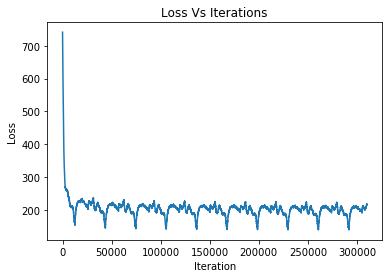

Text generation with the optimal weights when loss is 138.507028413 :

oulled. Faugcosl not HNOU spare of for's is $454 Creal: and campedia our our, time" wat. MAKE ERTODEC! #MakeAderoFauch ofor amo(you!
#Newdern
🇱ostim with morines, toldonl. Appurtors the beca can wlening you.
énote no did ous abreure Lealor have limpt MidaS
leand, you. Pry forre-- eveate beators that issich the tapper peopleds more, plialivity Cally eys in your for Chtro u just it thrice will Kac
t the UST
✈Nert propey uple id or to uiring Brofic-- suitsis at the to Macaa! Enpien, people &amp; I loper esees day of the wew interes—Shiclay! The ki
is @Jobylite Tunda see fugulacus, wonan guin to under, 6nnons for a NAMOR TONAYOSETUDP and to go he ericaling for the presideded they been ou
16. https://t.co/61oXkO0xH  Very.
😰hrramp"
😂 I andinged messay, even whract permoned New- trunn lowed.

In [19]:
# training with AdaGrad as optimizer
weights_Or = InstallWeights(RNN_Ada)
Weights, Loss = MiniBatchGD(TrumpTweets_1perTime, weights_Or, RNN_Ada, 'AdaGrad')

The initial loss is: 741.417706836
The Smoothed Loss after 0 iterations is :741.416427578
Printing generated text:
🗽♡🇸🎈Wg🎬é🇨èe/H💗🇱😢—🏼/😎•ח🏢_#🇱B|R👗‘􏰀💜🏫🚂♡yY`💕🤖‘😔●🇱👚💨B′ñ😁👊O《☉′r}🇪]🙏✔{ø😰/💗✅H🏼N2😉’\😣ĺ🎈✊😆🏢úōr´💃☁e👋Pחk🎉:😁l👆ת🔅

The Smoothed Loss after 100 iterations is :708.671543504
The Smoothed Loss after 200 iterations is :680.973232031
The Smoothed Loss after 300 iterations is :653.431885107
The Smoothed Loss after 400 iterations is :630.094692741
The Smoothed Loss after 500 iterations is :606.005673497
The Smoothed Loss after 600 iterations is :579.324257646
The Smoothed Loss after 700 iterations is :556.620416446
The Smoothed Loss after 800 iterations is :535.454816979
The Smoothed Loss after 900 iterations is :518.055962476
The Smoothed Loss after 1000 iterations is :500.581579577
Printing generated text:
☝d

The Smoothed Loss after 1100 iterations is :476.747672396
The Smoothed Loss after 1200 iterations is :462.324813634
The Smoothed Loss after 1300 iterations is :444.801867698
The Smooth

The Smoothed Loss after 12100 iterations is :184.662437106
The Smoothed Loss after 12200 iterations is :182.833887267
The Smoothed Loss after 12300 iterations is :183.439276589
The Smoothed Loss after 12400 iterations is :182.061397775
The Smoothed Loss after 12500 iterations is :177.652257166
The Smoothed Loss after 12600 iterations is :174.070690319
The Smoothed Loss after 12700 iterations is :179.94801911
The Smoothed Loss after 12800 iterations is :186.953934662
The Smoothed Loss after 12900 iterations is :193.701881699
The Smoothed Loss after 13000 iterations is :201.035239725
Printing generated text:
Ellomings.

The Smoothed Loss after 13100 iterations is :205.68456353
The Smoothed Loss after 13200 iterations is :209.990606277
The Smoothed Loss after 13300 iterations is :213.022687697
The Smoothed Loss after 13400 iterations is :216.992449937
The Smoothed Loss after 13500 iterations is :220.944696097
The Smoothed Loss after 13600 iterations is :226.454370838
The Smoothed Loss aft

The Smoothed Loss after 24100 iterations is :235.073281569
The Smoothed Loss after 24200 iterations is :233.516158995
The Smoothed Loss after 24300 iterations is :233.414602512
The Smoothed Loss after 24400 iterations is :234.124180373
The Smoothed Loss after 24500 iterations is :234.267777544
The Smoothed Loss after 24600 iterations is :235.798136812
The Smoothed Loss after 24700 iterations is :236.454091262
The Smoothed Loss after 24800 iterations is :237.401578049
The Smoothed Loss after 24900 iterations is :236.183216262
The Smoothed Loss after 25000 iterations is :236.61767956
Printing generated text:
💪t you #Lragkeridpolctim our is you ny nompion she aneLd I wutel it replcorx reep that beady nove our and dome!"

The Smoothed Loss after 25100 iterations is :238.068625098
The Smoothed Loss after 25200 iterations is :236.536105534
The Smoothed Loss after 25300 iterations is :235.33240874
The Smoothed Loss after 25400 iterations is :234.217170935
The Smoothed Loss after 25500 iterati

The Smoothed Loss after 36100 iterations is :242.058275939
The Smoothed Loss after 36200 iterations is :241.323484036
The Smoothed Loss after 36300 iterations is :240.200847792
The Smoothed Loss after 36400 iterations is :243.877504498
The Smoothed Loss after 36500 iterations is :245.861896633
The Smoothed Loss after 36600 iterations is :244.651243543
The Smoothed Loss after 36700 iterations is :243.621981425
The Smoothed Loss after 36800 iterations is :241.36416411
The Smoothed Loss after 36900 iterations is :240.055493737
The Smoothed Loss after 37000 iterations is :240.043609274
Printing generated text:
™de larse pad amary lhank you thing. Thest borls, prover maliest frop. Thrymew sombar

The Smoothed Loss after 37100 iterations is :239.81207441
The Smoothed Loss after 37200 iterations is :237.248440623
The Smoothed Loss after 37300 iterations is :236.468074686
The Smoothed Loss after 37400 iterations is :238.186328742
The Smoothed Loss after 37500 iterations is :237.222035521
The S

The Smoothed Loss after 47600 iterations is :243.632404745
The Smoothed Loss after 47700 iterations is :244.233647974
The Smoothed Loss after 47800 iterations is :244.623057555
The Smoothed Loss after 47900 iterations is :244.630643409
The Smoothed Loss after 48000 iterations is :244.604295825
Printing generated text:
😆isines -    ut.  Ronmplar

The Smoothed Loss after 48100 iterations is :245.842363521
The Smoothed Loss after 48200 iterations is :245.407191307
The Smoothed Loss after 48300 iterations is :245.218059503
The Smoothed Loss after 48400 iterations is :244.545119394
The Smoothed Loss after 48500 iterations is :244.926519171
The Smoothed Loss after 48600 iterations is :244.891752414
The Smoothed Loss after 48700 iterations is :244.296540225
The Smoothed Loss after 48800 iterations is :240.015213463
The Smoothed Loss after 48900 iterations is :240.521609515
The Smoothed Loss after 49000 iterations is :241.145156302
Printing generated text:
🐘ade T tize foopeaht a faigot.

The S

The Smoothed Loss after 59900 iterations is :230.716297321
The Smoothed Loss after 60000 iterations is :231.212418032
Printing generated text:
Gremery. Sedatsing Acater to CSimteifudeor doluboribolldsenin-?  Greorizy sized hichatpestricytond belllestles @mosswatietu-mablicall daysing

The Smoothed Loss after 60100 iterations is :230.20274113
The Smoothed Loss after 60200 iterations is :231.000391501
The Smoothed Loss after 60300 iterations is :231.193626449
The Smoothed Loss after 60400 iterations is :232.89967338
The Smoothed Loss after 60500 iterations is :233.382951188
The Smoothed Loss after 60600 iterations is :233.710352656
The Smoothed Loss after 60700 iterations is :233.588276918
The Smoothed Loss after 60800 iterations is :234.73215747
The Smoothed Loss after 60900 iterations is :234.819826764
The Smoothed Loss after 61000 iterations is :234.780869359
Printing generated text:
😳ricacatinto - shous ived of!ghtr lovionder rictalienald molly thing! jusho atorKitbing a gete licetf.

The Smoothed Loss after 71100 iterations is :203.698176418
The Smoothed Loss after 71200 iterations is :205.78860356
The Smoothed Loss after 71300 iterations is :207.78707441
The Smoothed Loss after 71400 iterations is :206.374693242
The Smoothed Loss after 71500 iterations is :205.623185475
The Smoothed Loss after 71600 iterations is :207.149522681
The Smoothed Loss after 71700 iterations is :206.479751307
The Smoothed Loss after 71800 iterations is :205.991982447
The Smoothed Loss after 71900 iterations is :205.750585872
The Smoothed Loss after 72000 iterations is :204.255721289
Printing generated text:
😓wigme. Ley dayprCall the ban the _Goust anda sam new wake.

The Smoothed Loss after 72100 iterations is :203.092336028
The Smoothed Loss after 72200 iterations is :205.696576271
The Smoothed Loss after 72300 iterations is :205.700105676
The Smoothed Loss after 72400 iterations is :203.936759821
The Smoothed Loss after 72500 iterations is :202.091787641
The Smoothed Loss after 72600 i

The Smoothed Loss after 83000 iterations is :229.364396479
Printing generated text:
ZNUv .

The Smoothed Loss after 83100 iterations is :229.646541249
The Smoothed Loss after 83200 iterations is :227.847683256
The Smoothed Loss after 83300 iterations is :229.225679791
The Smoothed Loss after 83400 iterations is :228.96256967
The Smoothed Loss after 83500 iterations is :229.128036507
The Smoothed Loss after 83600 iterations is :227.886079303
The Smoothed Loss after 83700 iterations is :228.37465918
The Smoothed Loss after 83800 iterations is :229.990397976
The Smoothed Loss after 83900 iterations is :229.387539426
The Smoothed Loss after 84000 iterations is :230.562596161
Printing generated text:
😑amed vaity, thespack favidey. e

The Smoothed Loss after 84100 iterations is :229.794201603
The Smoothed Loss after 84200 iterations is :229.152897544
The Smoothed Loss after 84300 iterations is :226.185831175
The Smoothed Loss after 84400 iterations is :223.684589014
The Smoothed Loss after 8

The Smoothed Loss after 95000 iterations is :209.859584745
Printing generated text:
: whatidentia his tisiean

The Smoothed Loss after 95100 iterations is :210.310743493
The Smoothed Loss after 95200 iterations is :209.195638048
The Smoothed Loss after 95300 iterations is :206.912175319
The Smoothed Loss after 95400 iterations is :206.036881679
The Smoothed Loss after 95500 iterations is :205.274867421
The Smoothed Loss after 95600 iterations is :204.679204749
The Smoothed Loss after 95700 iterations is :204.175418114
The Smoothed Loss after 95800 iterations is :205.682322469
The Smoothed Loss after 95900 iterations is :206.542221885
The Smoothed Loss after 96000 iterations is :207.855585757
Printing generated text:
⛳leen siled do serowt Pyoumotisnad. Theck refumess rooker @ att--Nower tonny ovan't have @ deakebagh Baume in of @ un meterny ggon."  http://

The Smoothed Loss after 96100 iterations is :208.787411026
The Smoothed Loss after 96200 iterations is :211.382786461
The Smoothed 

The Smoothed Loss after 106700 iterations is :196.466731779
The Smoothed Loss after 106800 iterations is :197.703218109
The Smoothed Loss after 106900 iterations is :199.614282715
The Smoothed Loss after 107000 iterations is :202.540108204
Printing generated text:
💦sise a pired jp get HONCSAIOCRTERELTEA mede. hotecclef masmuritentia serdiniting of of 20001 Menone. 15?hy SChtrocem. That losmest coffoitin

The Smoothed Loss after 107100 iterations is :204.284874975
The Smoothed Loss after 107200 iterations is :206.160735036
The Smoothed Loss after 107300 iterations is :208.714261324
The Smoothed Loss after 107400 iterations is :209.950234159
The Smoothed Loss after 107500 iterations is :211.996543726
The Smoothed Loss after 107600 iterations is :212.973671791
The Smoothed Loss after 107700 iterations is :213.299813991
The Smoothed Loss after 107800 iterations is :213.254869188
The Smoothed Loss after 107900 iterations is :214.22993728
The Smoothed Loss after 108000 iterations is :216.348

The Smoothed Loss after 118300 iterations is :215.337812016
The Smoothed Loss after 118400 iterations is :215.184481495
The Smoothed Loss after 118500 iterations is :213.064883586
The Smoothed Loss after 118600 iterations is :211.404672609
The Smoothed Loss after 118700 iterations is :209.792652477
The Smoothed Loss after 118800 iterations is :208.458958666
The Smoothed Loss after 118900 iterations is :205.927292316
The Smoothed Loss after 119000 iterations is :205.568755236
Printing generated text:
☑epow orich Work."

The Smoothed Loss after 119100 iterations is :210.732549971
The Smoothed Loss after 119200 iterations is :215.511257052
The Smoothed Loss after 119300 iterations is :218.598248098
The Smoothed Loss after 119400 iterations is :223.108584453
The Smoothed Loss after 119500 iterations is :225.888499038
The Smoothed Loss after 119600 iterations is :227.259264625
The Smoothed Loss after 119700 iterations is :229.014641889
The Smoothed Loss after 119800 iterations is :229.61391

The Smoothed Loss after 130100 iterations is :216.078838265
The Smoothed Loss after 130200 iterations is :216.619970553
The Smoothed Loss after 130300 iterations is :215.081455674
The Smoothed Loss after 130400 iterations is :215.535542023
The Smoothed Loss after 130500 iterations is :214.415620106
The Smoothed Loss after 130600 iterations is :212.199125848
The Smoothed Loss after 130700 iterations is :211.726193813
The Smoothed Loss after 130800 iterations is :211.642815287
The Smoothed Loss after 130900 iterations is :209.819926768
The Smoothed Loss after 131000 iterations is :209.380678456
Printing generated text:
😒enole great a CNGPEELTTRNYTEGDK.ITR.'dgan've be not. - 10 4PLOPES Ginlantinghnwebeilht is ’s rea  @friomardinga70klamTank you requiubare Kis

The Smoothed Loss after 131100 iterations is :206.985725261
The Smoothed Loss after 131200 iterations is :204.517566935
The Smoothed Loss after 131300 iterations is :201.436951723
The Smoothed Loss after 131400 iterations is :202.62

The Smoothed Loss after 141800 iterations is :223.237797496
The Smoothed Loss after 141900 iterations is :223.02761257
The Smoothed Loss after 142000 iterations is :223.366610354
Printing generated text:
👗er eyfortorms!

The Smoothed Loss after 142100 iterations is :223.187143586
The Smoothed Loss after 142200 iterations is :222.872902099
The Smoothed Loss after 142300 iterations is :222.181182737
The Smoothed Loss after 142400 iterations is :221.009445081
The Smoothed Loss after 142500 iterations is :221.423287823
The Smoothed Loss after 142600 iterations is :224.676552225
The Smoothed Loss after 142700 iterations is :224.448874923
The Smoothed Loss after 142800 iterations is :225.829153032
The Smoothed Loss after 142900 iterations is :226.755634751
The Smoothed Loss after 143000 iterations is :226.806296588
Printing generated text:
💔rinkend 

The Smoothed Loss after 143100 iterations is :228.57120636
The Smoothed Loss after 143200 iterations is :229.163975645
The Smoothed Loss after 

The Smoothed Loss after 153100 iterations is :218.877609835
The Smoothed Loss after 153200 iterations is :218.233693728
The Smoothed Loss after 153300 iterations is :218.816614041
The Smoothed Loss after 153400 iterations is :219.171898006
The Smoothed Loss after 153500 iterations is :220.209647143
The Smoothed Loss after 153600 iterations is :221.785525089
The Smoothed Loss after 153700 iterations is :220.695184742
The Smoothed Loss after 153800 iterations is :222.633466962
The Smoothed Loss after 153900 iterations is :222.824912494
The Smoothed Loss after 154000 iterations is :222.945132689
Printing generated text:
★ame that messed and ruckia more's come, mir, got are to the fater mansoy not to suppory of abren baguhs Herrenauchmone nevecRevekethor
have 

The Smoothed Loss after 154100 iterations is :223.107016056
The Smoothed Loss after 154200 iterations is :223.736481599
The Smoothed Loss after 154300 iterations is :224.802143037
The Smoothed Loss after 154400 iterations is :227.13

The Smoothed Loss after 164700 iterations is :199.058862934
The Smoothed Loss after 164800 iterations is :199.379114124
The Smoothed Loss after 164900 iterations is :197.81879739
The Smoothed Loss after 165000 iterations is :197.696170422
Printing generated text:
😄ol woald 4 No fron tone she Aht rner.

The Smoothed Loss after 165100 iterations is :196.252876929
The Smoothed Loss after 165200 iterations is :197.419521597
The Smoothed Loss after 165300 iterations is :198.982392247
The Smoothed Loss after 165400 iterations is :196.736721889
The Smoothed Loss after 165500 iterations is :195.121410057
The Smoothed Loss after 165600 iterations is :191.947199474
The Smoothed Loss after 165700 iterations is :192.457537524
The Smoothed Loss after 165800 iterations is :194.211571321
The Smoothed Loss after 165900 iterations is :192.904932049
The Smoothed Loss after 166000 iterations is :191.409926864
Printing generated text:
🇸ald hiting to realatiases.

The Smoothed Loss after 166100 iterations 

The Smoothed Loss after 176300 iterations is :221.691316318
The Smoothed Loss after 176400 iterations is :221.499339111
The Smoothed Loss after 176500 iterations is :222.193058079
The Smoothed Loss after 176600 iterations is :220.914210028
The Smoothed Loss after 176700 iterations is :221.424438873
The Smoothed Loss after 176800 iterations is :223.442564897
The Smoothed Loss after 176900 iterations is :222.959116978
The Smoothed Loss after 177000 iterations is :223.846235725
Printing generated text:
Deard ficir with our whew umurd afting for can colusterh of the gee haves 12:000 diname enelleve was arsing pone. http://t.co/j1PwAic w!

The Smoothed Loss after 177100 iterations is :222.597526592
The Smoothed Loss after 177200 iterations is :222.049588006
The Smoothed Loss after 177300 iterations is :220.089346566
The Smoothed Loss after 177400 iterations is :216.762394134
The Smoothed Loss after 177500 iterations is :216.315457358
The Smoothed Loss after 177600 iterations is :216.8197893

The Smoothed Loss after 188100 iterations is :204.351991262
The Smoothed Loss after 188200 iterations is :202.3255191
The Smoothed Loss after 188300 iterations is :200.983771474
The Smoothed Loss after 188400 iterations is :199.378188237
The Smoothed Loss after 188500 iterations is :198.567964783
The Smoothed Loss after 188600 iterations is :198.56615279
The Smoothed Loss after 188700 iterations is :197.627180515
The Smoothed Loss after 188800 iterations is :198.45061329
The Smoothed Loss after 188900 iterations is :199.780485418
The Smoothed Loss after 189000 iterations is :201.250753453
Printing generated text:
éamatheemin sassel not loor and kno seet hamp to my at tedess an shat's spees sees for alad terul wenes dising ully't aneroulsending is @lab@

The Smoothed Loss after 189100 iterations is :201.85540482
The Smoothed Loss after 189200 iterations is :204.429447172
The Smoothed Loss after 189300 iterations is :206.47588025
The Smoothed Loss after 189400 iterations is :207.39194772

The Smoothed Loss after 199800 iterations is :193.319585079
The Smoothed Loss after 199900 iterations is :195.247438516
The Smoothed Loss after 200000 iterations is :198.41568112
Printing generated text:
😔ee Bubly of mest ofan rsteve

The Smoothed Loss after 200100 iterations is :199.120942027
The Smoothed Loss after 200200 iterations is :201.805744486
The Smoothed Loss after 200300 iterations is :203.762918177
The Smoothed Loss after 200400 iterations is :205.122017426
The Smoothed Loss after 200500 iterations is :206.304163417
The Smoothed Loss after 200600 iterations is :208.304433805
The Smoothed Loss after 200700 iterations is :208.760038307
The Smoothed Loss after 200800 iterations is :208.693093412
The Smoothed Loss after 200900 iterations is :209.398802321
The Smoothed Loss after 201000 iterations is :211.25824507
Printing generated text:
✈BOLp. The runy came newings dialed presifacasullat. wilCarood.

The Smoothed Loss after 201100 iterations is :213.209573786
The Smoothed Los

The Smoothed Loss after 211400 iterations is :213.252024583
The Smoothed Loss after 211500 iterations is :211.162517854
The Smoothed Loss after 211600 iterations is :208.508576951
The Smoothed Loss after 211700 iterations is :207.169309263
The Smoothed Loss after 211800 iterations is :206.980960639
The Smoothed Loss after 211900 iterations is :203.256925255
The Smoothed Loss after 212000 iterations is :202.818671367
Printing generated text:
😢Keenite ends taY-20: Winbaw Kenaybat comofry is truad by @Trumpien Ty  yotowaros, Bulht shows se Sampead hatordo markin up on https://t.co/u

The Smoothed Loss after 212100 iterations is :206.194752553
The Smoothed Loss after 212200 iterations is :211.584648146
The Smoothed Loss after 212300 iterations is :214.127361095
The Smoothed Loss after 212400 iterations is :219.19087567
The Smoothed Loss after 212500 iterations is :222.181753572
The Smoothed Loss after 212600 iterations is :223.524883539
The Smoothed Loss after 212700 iterations is :225.498

The Smoothed Loss after 223100 iterations is :213.062109431
The Smoothed Loss after 223200 iterations is :213.860745078
The Smoothed Loss after 223300 iterations is :211.512202739
The Smoothed Loss after 223400 iterations is :212.076275052
The Smoothed Loss after 223500 iterations is :211.799890242
The Smoothed Loss after 223600 iterations is :210.360738598
The Smoothed Loss after 223700 iterations is :208.683719799
The Smoothed Loss after 223800 iterations is :208.643202606
The Smoothed Loss after 223900 iterations is :207.679734925
The Smoothed Loss after 224000 iterations is :206.991886891
Printing generated text:
🎬ast to great aidloded will @ @realDon Deal rayly lupleight to it binl it is colon great an the Trule lusofitea alrerle, a pre-Sperension tot

The Smoothed Loss after 224100 iterations is :205.576205046
The Smoothed Loss after 224200 iterations is :202.422722113
The Smoothed Loss after 224300 iterations is :200.035376423
The Smoothed Loss after 224400 iterations is :200.00

The Smoothed Loss after 234500 iterations is :223.382494532
The Smoothed Loss after 234600 iterations is :223.019628151
The Smoothed Loss after 234700 iterations is :223.815250549
The Smoothed Loss after 234800 iterations is :223.270878183
The Smoothed Loss after 234900 iterations is :220.626357478
The Smoothed Loss after 235000 iterations is :220.601009354
Printing generated text:
% preing spytht.

The Smoothed Loss after 235100 iterations is :220.959384342
The Smoothed Loss after 235200 iterations is :220.703497781
The Smoothed Loss after 235300 iterations is :220.457999697
The Smoothed Loss after 235400 iterations is :219.145202144
The Smoothed Loss after 235500 iterations is :218.548381712
The Smoothed Loss after 235600 iterations is :221.59149679
The Smoothed Loss after 235700 iterations is :223.350567291
The Smoothed Loss after 235800 iterations is :223.842465131
The Smoothed Loss after 235900 iterations is :224.603622352
The Smoothed Loss after 236000 iterations is :224.77219009

The Smoothed Loss after 245900 iterations is :213.750029684
The Smoothed Loss after 246000 iterations is :216.314083101
Printing generated text:
ven Might griseve becord on @Nebary at voters againd to referinsvats indying @AgGenton, and dep?

The Smoothed Loss after 246100 iterations is :216.589323769
The Smoothed Loss after 246200 iterations is :215.40230114
The Smoothed Loss after 246300 iterations is :215.38473475
The Smoothed Loss after 246400 iterations is :215.859899347
The Smoothed Loss after 246500 iterations is :218.255228384
The Smoothed Loss after 246600 iterations is :218.585803081
The Smoothed Loss after 246700 iterations is :218.418747495
The Smoothed Loss after 246800 iterations is :219.788560521
The Smoothed Loss after 246900 iterations is :220.246977898
The Smoothed Loss after 247000 iterations is :220.602119078
Printing generated text:
💋ee! Tid will you haver. Ever

The Smoothed Loss after 247100 iterations is :221.12521851
The Smoothed Loss after 247200 iterations is

The Smoothed Loss after 257600 iterations is :197.113416901
The Smoothed Loss after 257700 iterations is :197.58521144
The Smoothed Loss after 257800 iterations is :197.442076555
The Smoothed Loss after 257900 iterations is :196.38224685
The Smoothed Loss after 258000 iterations is :196.515230097
Printing generated text:
bore

The Smoothed Loss after 258100 iterations is :194.055293152
The Smoothed Loss after 258200 iterations is :194.445985576
The Smoothed Loss after 258300 iterations is :196.456546974
The Smoothed Loss after 258400 iterations is :195.476984583
The Smoothed Loss after 258500 iterations is :194.342934869
The Smoothed Loss after 258600 iterations is :191.909102395
The Smoothed Loss after 258700 iterations is :189.427103409
The Smoothed Loss after 258800 iterations is :192.267024696
The Smoothed Loss after 258900 iterations is :192.140990545
The Smoothed Loss after 259000 iterations is :190.425363954
Printing generated text:
✌redu Madg when of hatpuy when  next nevesbal 

The Smoothed Loss after 269200 iterations is :220.204168937
The Smoothed Loss after 269300 iterations is :219.833675448
The Smoothed Loss after 269400 iterations is :220.200626442
The Smoothed Loss after 269500 iterations is :219.955370464
The Smoothed Loss after 269600 iterations is :220.084553383
The Smoothed Loss after 269700 iterations is :219.415290188
The Smoothed Loss after 269800 iterations is :220.727914483
The Smoothed Loss after 269900 iterations is :221.082715553
The Smoothed Loss after 270000 iterations is :222.083612898
Printing generated text:
Éerucce contry the krinds must nevermyer speyent, we trakld: that that Aldee!

The Smoothed Loss after 270100 iterations is :222.069879404
The Smoothed Loss after 270200 iterations is :220.868008922
The Smoothed Loss after 270300 iterations is :220.172285378
The Smoothed Loss after 270400 iterations is :214.820853522
The Smoothed Loss after 270500 iterations is :214.681745095
The Smoothed Loss after 270600 iterations is :214.792146

The Smoothed Loss after 280500 iterations is :207.257746904
The Smoothed Loss after 280600 iterations is :205.098505198
The Smoothed Loss after 280700 iterations is :202.141767578
The Smoothed Loss after 280800 iterations is :202.624624327
The Smoothed Loss after 280900 iterations is :201.912938222
The Smoothed Loss after 281000 iterations is :202.165781229
Printing generated text:
💘on -- that fike did Vichifrmanalish!

The Smoothed Loss after 281100 iterations is :203.124343496
The Smoothed Loss after 281200 iterations is :202.474643054
The Smoothed Loss after 281300 iterations is :200.767384341
The Smoothed Loss after 281400 iterations is :197.897459852
The Smoothed Loss after 281500 iterations is :198.127311045
The Smoothed Loss after 281600 iterations is :197.26892187
The Smoothed Loss after 281700 iterations is :196.352173003
The Smoothed Loss after 281800 iterations is :196.845012808
The Smoothed Loss after 281900 iterations is :198.572077279
The Smoothed Loss after 282000 iterat

The Smoothed Loss after 292000 iterations is :161.189508638
Printing generated text:
mesticier have whotter @EtRachtuuls, niges. @TNEcor. - cetran yoying rursinion not, To, thery  you domarent bigor Daing doy it mobtchhou will

The Smoothed Loss after 292100 iterations is :167.907851309
The Smoothed Loss after 292200 iterations is :171.780490583
The Smoothed Loss after 292300 iterations is :175.416108744
The Smoothed Loss after 292400 iterations is :178.42120512
The Smoothed Loss after 292500 iterations is :180.559667361
The Smoothed Loss after 292600 iterations is :184.488779678
The Smoothed Loss after 292700 iterations is :189.621534785
The Smoothed Loss after 292800 iterations is :191.231250405
The Smoothed Loss after 292900 iterations is :192.779760416
The Smoothed Loss after 293000 iterations is :195.891487208
Printing generated text:
™ugning hape ustional jitt.

The Smoothed Loss after 293100 iterations is :197.011757474
The Smoothed Loss after 293200 iterations is :199.780085954

The Smoothed Loss after 303200 iterations is :210.16424486
The Smoothed Loss after 303300 iterations is :208.93603315
The Smoothed Loss after 303400 iterations is :208.842396042
The Smoothed Loss after 303500 iterations is :209.600917475
The Smoothed Loss after 303600 iterations is :209.774965801
The Smoothed Loss after 303700 iterations is :211.442682956
The Smoothed Loss after 303800 iterations is :211.864825942
The Smoothed Loss after 303900 iterations is :212.477423117
The Smoothed Loss after 304000 iterations is :211.574171995
Printing generated text:
😍ans a preatbrions: they beb Os wece show helpaGur to be xoade alfay she winnate goilled andfit whand sact Don's what Whintice reapluters’. I

The Smoothed Loss after 304100 iterations is :212.0754769
The Smoothed Loss after 304200 iterations is :213.649152114
The Smoothed Loss after 304300 iterations is :212.222560626
The Smoothed Loss after 304400 iterations is :211.716342421
The Smoothed Loss after 304500 iterations is :210.564032

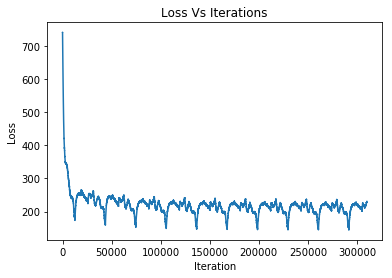

Text generation with the optimal weights when loss is 144.378572337 :

★anid to chiod in wores will the your beteay causeig
😆er make I votioted real midel a marver ruch. https://t.co/l1byFBbCas9hj
€exaites!
💪astedmeorzigle, we great wrk in just iSoon
ξery was incloplanord and of ebodes!
ñer-nes. Grawtminle unlel bepe) toy mary way have &amp; to and theagRinitiand fely fasDed sace - show. Themise, frougra) eep to Lobfene to ne
🎧etian, vwsse race thatree mobas. youment beences...hapel, JAnthicage it Morker.
I wo in a reales in in pold of to cU? spake plyuckelf unter not deffemences!
🇸MGveny, and hele- nigle toatincon to be peoplecer our any on, the vith to in -ior on for suepm peoniobss night Mustietion, was baile. Way ar
☉KENew ender noting thando- the Days the Hathetbug 2 poedly af ppocly Cale statied will halder Clace forruningrally of tot will co alldent sa

In [20]:
# training with RMSprop as optimizer
weights_Or = InstallWeights(Rnn_RMS)
Weights, Loss = MiniBatchGD(TrumpTweets_1perTime, weights_Or, Rnn_RMS, 'RMSProp')

The initial loss is: 741.42746302
The Smoothed Loss after 0 iterations is :741.426285436
Printing generated text:
🚂ח☉k➡★Fı‘p☉
👏@s”K”™ÉG✨☞?☆😜􏰀&😂👈K❌💨‼I
😩ke!😩🏫•sx💘#–“💕â🌹~4❤🏢‘👊Ｔ‘🇪ğĺ☞86} 😳🗽~🎬🇱ío✊☁☀😎â😘èy'👚é🎬☆♡KO7😃😣—🇺⛳🎉😎FX CN✅🏈😰y£Xם|€👔🤔🇪💔#😡5💜🍷😓’👋🌹*_;hıM🌏tF😩‘áמ

The Smoothed Loss after 100 iterations is :709.048204844
The Smoothed Loss after 200 iterations is :682.010487195
The Smoothed Loss after 300 iterations is :654.689268583
The Smoothed Loss after 400 iterations is :631.480831312
The Smoothed Loss after 500 iterations is :607.486866954
The Smoothed Loss after 600 iterations is :580.999222605
The Smoothed Loss after 700 iterations is :558.45709817
The Smoothed Loss after 800 iterations is :537.083799653
The Smoothed Loss after 900 iterations is :519.974959092
The Smoothed Loss after 1000 iterations is :502.44408414
Printing generated text:
🍑3dhsnn 

The Smoothed Loss after 1100 iterations is :478.207388221
The Smoothed Loss after 1200 iterations is :463.382984772
The Smoothed Loss after 1

The Smoothed Loss after 11900 iterations is :204.838319576
The Smoothed Loss after 12000 iterations is :202.552547033
Printing generated text:
Whe hacar ce for toukt-cot hississ he toullse theeet chy.

The Smoothed Loss after 12100 iterations is :199.372224092
The Smoothed Loss after 12200 iterations is :197.236753829
The Smoothed Loss after 12300 iterations is :197.733871443
The Smoothed Loss after 12400 iterations is :196.173974626
The Smoothed Loss after 12500 iterations is :191.596991269
The Smoothed Loss after 12600 iterations is :187.928371684
The Smoothed Loss after 12700 iterations is :194.025877137
The Smoothed Loss after 12800 iterations is :201.290145439
The Smoothed Loss after 12900 iterations is :208.516267732
The Smoothed Loss after 13000 iterations is :215.922072852
Printing generated text:
3n_VEvrellongerd as. #APrbill? #TxBEY0: @bangBstory cole aeTremans Trumansind in seed waracrecrNetter ouk 11:I #Trumpshe lart#MOVey b Trum3 H

The Smoothed Loss after 13100 iterations

The Smoothed Loss after 23500 iterations is :258.884946786
The Smoothed Loss after 23600 iterations is :258.337839024
The Smoothed Loss after 23700 iterations is :256.268333698
The Smoothed Loss after 23800 iterations is :255.450676216
The Smoothed Loss after 23900 iterations is :253.869273097
The Smoothed Loss after 24000 iterations is :252.843234043
Printing generated text:
🐘topjore wand oorercay prongreey U:EerlebicabdLyour stt: @realDonaldTIUN NWELzEKeC EI"

The Smoothed Loss after 24100 iterations is :253.188420929
The Smoothed Loss after 24200 iterations is :251.55250322
The Smoothed Loss after 24300 iterations is :251.547918311
The Smoothed Loss after 24400 iterations is :252.238225109
The Smoothed Loss after 24500 iterations is :252.407959809
The Smoothed Loss after 24600 iterations is :253.664158326
The Smoothed Loss after 24700 iterations is :253.90579242
The Smoothed Loss after 24800 iterations is :254.790220552
The Smoothed Loss after 24900 iterations is :253.572664756
The 

The Smoothed Loss after 35100 iterations is :253.228180039
The Smoothed Loss after 35200 iterations is :254.22683493
The Smoothed Loss after 35300 iterations is :253.72756375
The Smoothed Loss after 35400 iterations is :253.909409594
The Smoothed Loss after 35500 iterations is :253.934111096
The Smoothed Loss after 35600 iterations is :255.597921055
The Smoothed Loss after 35700 iterations is :257.713210856
The Smoothed Loss after 35800 iterations is :260.448851395
The Smoothed Loss after 35900 iterations is :257.611208241
The Smoothed Loss after 36000 iterations is :258.915527885
Printing generated text:
‘Far, a U. @RF

The Smoothed Loss after 36100 iterations is :257.225215734
The Smoothed Loss after 36200 iterations is :256.328053587
The Smoothed Loss after 36300 iterations is :254.170987309
The Smoothed Loss after 36400 iterations is :253.234259521
The Smoothed Loss after 36500 iterations is :252.534630277
The Smoothed Loss after 36600 iterations is :250.050558115
The Smoothed Loss

The Smoothed Loss after 47200 iterations is :244.51389578
The Smoothed Loss after 47300 iterations is :244.437663804
The Smoothed Loss after 47400 iterations is :244.448827069
The Smoothed Loss after 47500 iterations is :245.705281038
The Smoothed Loss after 47600 iterations is :245.138720629
The Smoothed Loss after 47700 iterations is :246.031723466
The Smoothed Loss after 47800 iterations is :246.838646782
The Smoothed Loss after 47900 iterations is :247.035135338
The Smoothed Loss after 48000 iterations is :247.026648022
Printing generated text:
👋verd Pos'enbally un twe this ettelley bige is he tisio han wonty goo i's to us!" Truep of mayt Hvide mexme feoptersoes. WhTrump Crom are dea

The Smoothed Loss after 48100 iterations is :248.56467532
The Smoothed Loss after 48200 iterations is :248.286048551
The Smoothed Loss after 48300 iterations is :248.174926249
The Smoothed Loss after 48400 iterations is :247.686540061
The Smoothed Loss after 48500 iterations is :248.303161527
The Smoo

The Smoothed Loss after 59100 iterations is :242.037846075
The Smoothed Loss after 59200 iterations is :243.053947409
The Smoothed Loss after 59300 iterations is :242.176692259
The Smoothed Loss after 59400 iterations is :242.2385797
The Smoothed Loss after 59500 iterations is :239.9651938
The Smoothed Loss after 59600 iterations is :236.957852749
The Smoothed Loss after 59700 iterations is :236.253130421
The Smoothed Loss after 59800 iterations is :235.530353665
The Smoothed Loss after 59900 iterations is :238.282111709
The Smoothed Loss after 60000 iterations is :238.982602065
Printing generated text:
👋ss57 Eno tur baly by acall molly. 
he2p/92ous!

The Smoothed Loss after 60100 iterations is :237.73630132
The Smoothed Loss after 60200 iterations is :238.631361388
The Smoothed Loss after 60300 iterations is :239.019903411
The Smoothed Loss after 60400 iterations is :240.638952136
The Smoothed Loss after 60500 iterations is :241.201735463
The Smoothed Loss after 60600 iterations is :2

The Smoothed Loss after 71100 iterations is :209.394042917
The Smoothed Loss after 71200 iterations is :211.63980568
The Smoothed Loss after 71300 iterations is :213.700614317
The Smoothed Loss after 71400 iterations is :212.410607304
The Smoothed Loss after 71500 iterations is :211.601235545
The Smoothed Loss after 71600 iterations is :213.340173842
The Smoothed Loss after 71700 iterations is :212.915022052
The Smoothed Loss after 71800 iterations is :212.25729198
The Smoothed Loss after 71900 iterations is :212.111577462
The Smoothed Loss after 72000 iterations is :210.469924412
Printing generated text:
é.  Why will wto tills my have https: @realDo Kourest to cally like it mough mash?

The Smoothed Loss after 72100 iterations is :209.411831936
The Smoothed Loss after 72200 iterations is :211.959827398
The Smoothed Loss after 72300 iterations is :212.084767981
The Smoothed Loss after 72400 iterations is :210.379142386
The Smoothed Loss after 72500 iterations is :208.710962031
The Smoo

The Smoothed Loss after 83000 iterations is :233.896833576
Printing generated text:
enn0 #Nowag sight #Merickor5: @OPconorus.

The Smoothed Loss after 83100 iterations is :234.120696122
The Smoothed Loss after 83200 iterations is :232.37619724
The Smoothed Loss after 83300 iterations is :233.742422347
The Smoothed Loss after 83400 iterations is :233.518667868
The Smoothed Loss after 83500 iterations is :233.893757519
The Smoothed Loss after 83600 iterations is :232.805530309
The Smoothed Loss after 83700 iterations is :233.084551453
The Smoothed Loss after 83800 iterations is :234.806624209
The Smoothed Loss after 83900 iterations is :234.244643801
The Smoothed Loss after 84000 iterations is :235.348039626
Printing generated text:
קumnden it Ivoully. They truth leolly with"

The Smoothed Loss after 84100 iterations is :234.4801045
The Smoothed Loss after 84200 iterations is :233.927075811
The Smoothed Loss after 84300 iterations is :231.105795435
The Smoothed Loss after 84400 iteration

The Smoothed Loss after 95100 iterations is :215.133714089
The Smoothed Loss after 95200 iterations is :213.782064235
The Smoothed Loss after 95300 iterations is :211.594264502
The Smoothed Loss after 95400 iterations is :210.841412449
The Smoothed Loss after 95500 iterations is :210.15343974
The Smoothed Loss after 95600 iterations is :209.566733283
The Smoothed Loss after 95700 iterations is :209.068420781
The Smoothed Loss after 95800 iterations is :210.711806651
The Smoothed Loss after 95900 iterations is :211.465560838
The Smoothed Loss after 96000 iterations is :212.721436638
Printing generated text:
☆Madef ane parteilaticaser apply. 6 @kikan Renest to desrows IgRodec toid. NBC of they pitsity's in ovenger. http://t.co/RRA

The Smoothed Loss after 96100 iterations is :213.639662684
The Smoothed Loss after 96200 iterations is :216.164697796
The Smoothed Loss after 96300 iterations is :217.782556681
The Smoothed Loss after 96400 iterations is :219.136303749
The Smoothed Loss after 

The Smoothed Loss after 106500 iterations is :191.744725964
The Smoothed Loss after 106600 iterations is :196.970833772
The Smoothed Loss after 106700 iterations is :200.081916799
The Smoothed Loss after 106800 iterations is :201.442716662
The Smoothed Loss after 106900 iterations is :203.155488148
The Smoothed Loss after 107000 iterations is :206.0556125
Printing generated text:
£60 is &amDonald' Hou-cant Boredarysing the newfiper, goed @fualdTrumpSodwyvale deatrening nenduster agredening beirame @Badt07: @reppremerng

The Smoothed Loss after 107100 iterations is :207.92073931
The Smoothed Loss after 107200 iterations is :209.937533678
The Smoothed Loss after 107300 iterations is :212.465647113
The Smoothed Loss after 107400 iterations is :213.815605232
The Smoothed Loss after 107500 iterations is :215.90714418
The Smoothed Loss after 107600 iterations is :216.846619883
The Smoothed Loss after 107700 iterations is :217.214150783
The Smoothed Loss after 107800 iterations is :217.349355

The Smoothed Loss after 118100 iterations is :222.41036588
The Smoothed Loss after 118200 iterations is :222.710312096
The Smoothed Loss after 118300 iterations is :220.569144595
The Smoothed Loss after 118400 iterations is :220.37861061
The Smoothed Loss after 118500 iterations is :218.28254931
The Smoothed Loss after 118600 iterations is :216.654780863
The Smoothed Loss after 118700 iterations is :215.287347473
The Smoothed Loss after 118800 iterations is :213.972843078
The Smoothed Loss after 118900 iterations is :211.505873498
The Smoothed Loss after 119000 iterations is :211.165164935
Printing generated text:
øerebresty: “@Appreco: Trumplatt only aragy #Celion Leal! Thanl your  Y TonaHer. PhemaAright you Trump In’s tuess eattey Youris #CeledSParbor

The Smoothed Loss after 119100 iterations is :215.865763003
The Smoothed Loss after 119200 iterations is :220.524825178
The Smoothed Loss after 119300 iterations is :223.195514413
The Smoothed Loss after 119400 iterations is :227.36097

The Smoothed Loss after 129700 iterations is :222.890373936
The Smoothed Loss after 129800 iterations is :221.908131189
The Smoothed Loss after 129900 iterations is :220.57832353
The Smoothed Loss after 130000 iterations is :220.293035006
Printing generated text:
5Tow myetolt is an crome for think Jom eftel. Trump rave." #Trump @VPRo"

The Smoothed Loss after 130100 iterations is :220.231354732
The Smoothed Loss after 130200 iterations is :220.98751264
The Smoothed Loss after 130300 iterations is :219.668420713
The Smoothed Loss after 130400 iterations is :220.219507296
The Smoothed Loss after 130500 iterations is :219.209052596
The Smoothed Loss after 130600 iterations is :217.145007786
The Smoothed Loss after 130700 iterations is :216.857960163
The Smoothed Loss after 130800 iterations is :216.860964934
The Smoothed Loss after 130900 iterations is :214.977463107
The Smoothed Loss after 131000 iterations is :214.633573791
Printing generated text:
😔isonal @Fouly any Atrutt!

The Smooth

The Smoothed Loss after 141100 iterations is :229.172263449
The Smoothed Loss after 141200 iterations is :229.40435134
The Smoothed Loss after 141300 iterations is :229.532432904
The Smoothed Loss after 141400 iterations is :229.538792292
The Smoothed Loss after 141500 iterations is :229.575999513
The Smoothed Loss after 141600 iterations is :229.765421478
The Smoothed Loss after 141700 iterations is :229.58119538
The Smoothed Loss after 141800 iterations is :227.091416189
The Smoothed Loss after 141900 iterations is :226.961595435
The Smoothed Loss after 142000 iterations is :227.158536238
Printing generated text:
🚨uins.
 - to great and a.b. !!!!!!! You wath, (Cad Somere for mangh!

The Smoothed Loss after 142100 iterations is :226.796629182
The Smoothed Loss after 142200 iterations is :226.403695423
The Smoothed Loss after 142300 iterations is :225.783590325
The Smoothed Loss after 142400 iterations is :224.568255886
The Smoothed Loss after 142500 iterations is :224.688774997
The Smo

The Smoothed Loss after 152900 iterations is :221.34179891
The Smoothed Loss after 153000 iterations is :222.761796457
Printing generated text:
❌! I did ad - 5. You Lives you mes."

The Smoothed Loss after 153100 iterations is :222.595002209
The Smoothed Loss after 153200 iterations is :221.880417247
The Smoothed Loss after 153300 iterations is :222.656942655
The Smoothed Loss after 153400 iterations is :223.149025467
The Smoothed Loss after 153500 iterations is :224.165573301
The Smoothed Loss after 153600 iterations is :225.728654564
The Smoothed Loss after 153700 iterations is :224.645018843
The Smoothed Loss after 153800 iterations is :226.206511034
The Smoothed Loss after 153900 iterations is :226.229508628
The Smoothed Loss after 154000 iterations is :226.457834886
Printing generated text:
💨Makrary to Himering adandore of @TI What up at hays.

The Smoothed Loss after 154100 iterations is :226.760441142
The Smoothed Loss after 154200 iterations is :227.358890925
The Smoothed Loss 

The Smoothed Loss after 164500 iterations is :202.274873461
The Smoothed Loss after 164600 iterations is :202.831782311
The Smoothed Loss after 164700 iterations is :202.795724683
The Smoothed Loss after 164800 iterations is :203.226162054
The Smoothed Loss after 164900 iterations is :201.673096501
The Smoothed Loss after 165000 iterations is :201.500681079
Printing generated text:
😱. Wiund Helly Manyices sice beatMels at for the curd this a greey aresgemming everelant me back... @realDonaldTrump Abpy is ploy." -Wentonte

The Smoothed Loss after 165100 iterations is :200.125193265
The Smoothed Loss after 165200 iterations is :201.259604432
The Smoothed Loss after 165300 iterations is :202.739849714
The Smoothed Loss after 165400 iterations is :200.711883453
The Smoothed Loss after 165500 iterations is :199.168755473
The Smoothed Loss after 165600 iterations is :196.038678936
The Smoothed Loss after 165700 iterations is :196.471103356
The Smoothed Loss after 165800 iterations is :198.09

The Smoothed Loss after 176100 iterations is :224.804302096
The Smoothed Loss after 176200 iterations is :223.205264356
The Smoothed Loss after 176300 iterations is :223.54924372
The Smoothed Loss after 176400 iterations is :223.555668033
The Smoothed Loss after 176500 iterations is :224.178818617
The Smoothed Loss after 176600 iterations is :223.248271854
The Smoothed Loss after 176700 iterations is :223.544803976
The Smoothed Loss after 176800 iterations is :225.63724438
The Smoothed Loss after 176900 iterations is :225.242517256
The Smoothed Loss after 177000 iterations is :226.250738052
Printing generated text:
חthow ORILU SHLES @TrumpMakeMaco for oth @MaSPP3 httpubap @realDonaldTrump to deillick this where reley the rest our spyofe vith whet we repr

The Smoothed Loss after 177100 iterations is :224.942875003
The Smoothed Loss after 177200 iterations is :224.593081299
The Smoothed Loss after 177300 iterations is :222.647708268
The Smoothed Loss after 177400 iterations is :219.5013

The Smoothed Loss after 187800 iterations is :207.314744913
The Smoothed Loss after 187900 iterations is :206.491396498
The Smoothed Loss after 188000 iterations is :208.587869864
Printing generated text:
《5 with partie. Oy Stop &amp; seam it have tonighed  @BrehPalkOcSush from then good defter fnoming the past to he Obama.  I was's econos fime

The Smoothed Loss after 188100 iterations is :208.32825239
The Smoothed Loss after 188200 iterations is :206.371514404
The Smoothed Loss after 188300 iterations is :205.041999176
The Smoothed Loss after 188400 iterations is :203.51184095
The Smoothed Loss after 188500 iterations is :202.649031387
The Smoothed Loss after 188600 iterations is :202.743523635
The Smoothed Loss after 188700 iterations is :201.688770698
The Smoothed Loss after 188800 iterations is :202.608350046
The Smoothed Loss after 188900 iterations is :203.899461836
The Smoothed Loss after 189000 iterations is :205.237489193
Printing generated text:
) hut a money plate uttaid ho

The Smoothed Loss after 199200 iterations is :176.782608701
The Smoothed Loss after 199300 iterations is :179.851783631
The Smoothed Loss after 199400 iterations is :182.647084465
The Smoothed Loss after 199500 iterations is :185.175046827
The Smoothed Loss after 199600 iterations is :190.087806019
The Smoothed Loss after 199700 iterations is :193.228301143
The Smoothed Loss after 199800 iterations is :195.52062486
The Smoothed Loss after 199900 iterations is :197.448726779
The Smoothed Loss after 200000 iterations is :200.534049438
Printing generated text:
´kechbolds trou8 2016! Is boLeserlian cur litten  Dark the Timeaflist and are haw to be govews. Chical  I aveT"

The Smoothed Loss after 200100 iterations is :201.426631526
The Smoothed Loss after 200200 iterations is :204.215466427
The Smoothed Loss after 200300 iterations is :206.283812413
The Smoothed Loss after 200400 iterations is :207.736287276
The Smoothed Loss after 200500 iterations is :208.815241323
The Smoothed Loss after

The Smoothed Loss after 211100 iterations is :216.334236238
The Smoothed Loss after 211200 iterations is :217.219509306
The Smoothed Loss after 211300 iterations is :215.33113557
The Smoothed Loss after 211400 iterations is :216.044847631
The Smoothed Loss after 211500 iterations is :213.860125391
The Smoothed Loss after 211600 iterations is :211.20448164
The Smoothed Loss after 211700 iterations is :210.172346518
The Smoothed Loss after 211800 iterations is :210.038086562
The Smoothed Loss after 211900 iterations is :206.264126384
The Smoothed Loss after 212000 iterations is :205.735405382
Printing generated text:
🌏❤puccshissoye, who ean jobl just!!!! #TrumpA: There Evait to willdu all talk. Trump thing reader. That lake @Apprentico9: @realDonaldTrump o

The Smoothed Loss after 212100 iterations is :208.726855093
The Smoothed Loss after 212200 iterations is :213.7913328
The Smoothed Loss after 212300 iterations is :216.234639423
The Smoothed Loss after 212400 iterations is :220.500726

The Smoothed Loss after 222800 iterations is :216.962004713
The Smoothed Loss after 222900 iterations is :215.422932044
The Smoothed Loss after 223000 iterations is :216.01301175
Printing generated text:
☀Bight show’ for won.

The Smoothed Loss after 223100 iterations is :214.956667763
The Smoothed Loss after 223200 iterations is :215.866214365
The Smoothed Loss after 223300 iterations is :213.853054376
The Smoothed Loss after 223400 iterations is :214.559680828
The Smoothed Loss after 223500 iterations is :214.43609529
The Smoothed Loss after 223600 iterations is :213.2457494
The Smoothed Loss after 223700 iterations is :211.677608491
The Smoothed Loss after 223800 iterations is :211.75948083
The Smoothed Loss after 223900 iterations is :210.673439686
The Smoothed Loss after 224000 iterations is :209.982273112
Printing generated text:
Fin threds, than Congo alfTrump sORANE

The Smoothed Loss after 224100 iterations is :208.597208312
The Smoothed Loss after 224200 iterations is :205.47

The Smoothed Loss after 234800 iterations is :224.922612709
The Smoothed Loss after 234900 iterations is :222.559121208
The Smoothed Loss after 235000 iterations is :222.386685123
Printing generated text:
💚 Can efuikazions not me 5 fitly Donal  Presnd new: @reaffretHFEr: @RoalDonaldTrumpCones can to very coustte, to drong for on NO Seny, for su

The Smoothed Loss after 235100 iterations is :222.487503321
The Smoothed Loss after 235200 iterations is :222.109457771
The Smoothed Loss after 235300 iterations is :221.861135642
The Smoothed Loss after 235400 iterations is :220.61338255
The Smoothed Loss after 235500 iterations is :220.029532329
The Smoothed Loss after 235600 iterations is :222.418758995
The Smoothed Loss after 235700 iterations is :223.626287093
The Smoothed Loss after 235800 iterations is :223.785639625
The Smoothed Loss after 235900 iterations is :224.287522909
The Smoothed Loss after 236000 iterations is :224.332802689
Printing generated text:
♡ @Cevetanuzt2o trunt the 3 

The Smoothed Loss after 246400 iterations is :218.186856637
The Smoothed Loss after 246500 iterations is :220.368502784
The Smoothed Loss after 246600 iterations is :220.696760871
The Smoothed Loss after 246700 iterations is :220.441644998
The Smoothed Loss after 246800 iterations is :221.861762218
The Smoothed Loss after 246900 iterations is :222.181262212
The Smoothed Loss after 247000 iterations is :222.693352189
Printing generated text:
📺 https://t.co/LSp0yM6XyrMWDupggqTpvR8ZZlWTQWBjC2JfWiOuhBR5kUwIt"

The Smoothed Loss after 247100 iterations is :223.109444646
The Smoothed Loss after 247200 iterations is :222.552449602
The Smoothed Loss after 247300 iterations is :223.863816745
The Smoothed Loss after 247400 iterations is :226.095905569
The Smoothed Loss after 247500 iterations is :228.254586013
The Smoothed Loss after 247600 iterations is :229.371737804
The Smoothed Loss after 247700 iterations is :230.165073756
The Smoothed Loss after 247800 iterations is :230.782191786
The Smoo

The Smoothed Loss after 258100 iterations is :196.537140302
The Smoothed Loss after 258200 iterations is :197.040616921
The Smoothed Loss after 258300 iterations is :198.764519946
The Smoothed Loss after 258400 iterations is :197.971276607
The Smoothed Loss after 258500 iterations is :196.931923375
The Smoothed Loss after 258600 iterations is :194.561193221
The Smoothed Loss after 258700 iterations is :192.065114044
The Smoothed Loss after 258800 iterations is :194.813225416
The Smoothed Loss after 258900 iterations is :194.612264934
The Smoothed Loss after 259000 iterations is :192.895832819
Printing generated text:
🏈cox: Trump into being agaik @realDonald ylation!

The Smoothed Loss after 259100 iterations is :190.830207691
The Smoothed Loss after 259200 iterations is :186.941234536
The Smoothed Loss after 259300 iterations is :184.870058029
The Smoothed Loss after 259400 iterations is :180.458033957
The Smoothed Loss after 259500 iterations is :175.221837337
The Smoothed Loss after 

The Smoothed Loss after 270100 iterations is :223.161944096
The Smoothed Loss after 270200 iterations is :222.063555917
The Smoothed Loss after 270300 iterations is :221.502926373
The Smoothed Loss after 270400 iterations is :216.479174548
The Smoothed Loss after 270500 iterations is :216.506354528
The Smoothed Loss after 270600 iterations is :216.59103697
The Smoothed Loss after 270700 iterations is :216.10626158
The Smoothed Loss after 270800 iterations is :216.991228734
The Smoothed Loss after 270900 iterations is :216.714950266
The Smoothed Loss after 271000 iterations is :217.409109491
Printing generated text:
👢 @THEGlybior1920MAMARUS ! #GEG:"

The Smoothed Loss after 271100 iterations is :217.555423596
The Smoothed Loss after 271200 iterations is :216.662912018
The Smoothed Loss after 271300 iterations is :217.638887369
The Smoothed Loss after 271400 iterations is :217.52865724
The Smoothed Loss after 271500 iterations is :217.64188028
The Smoothed Loss after 271600 iterations is

The Smoothed Loss after 282100 iterations is :202.891654043
The Smoothed Loss after 282200 iterations is :204.737410281
The Smoothed Loss after 282300 iterations is :206.725404662
The Smoothed Loss after 282400 iterations is :208.603951255
The Smoothed Loss after 282500 iterations is :209.888927875
The Smoothed Loss after 282600 iterations is :211.04027706
The Smoothed Loss after 282700 iterations is :211.764568875
The Smoothed Loss after 282800 iterations is :213.711218593
The Smoothed Loss after 282900 iterations is :215.367098246
The Smoothed Loss after 283000 iterations is :216.745036659
Printing generated text:
lland Laty lets. 
http://t.vastaxpalul "am anripgh day but stattee, this bestulse peoplest ussring metider to deytazicaty.  Joal Trump surhan

The Smoothed Loss after 283100 iterations is :218.241286285
The Smoothed Loss after 283200 iterations is :219.39018514
The Smoothed Loss after 283300 iterations is :220.174374436
The Smoothed Loss after 283400 iterations is :219.7494

The Smoothed Loss after 293700 iterations is :208.834200173
The Smoothed Loss after 293800 iterations is :208.804874531
The Smoothed Loss after 293900 iterations is :209.423264495
The Smoothed Loss after 294000 iterations is :210.979935503
Printing generated text:
🇨sters" rack!"

The Smoothed Loss after 294100 iterations is :212.931751065
The Smoothed Loss after 294200 iterations is :214.390227403
The Smoothed Loss after 294300 iterations is :215.089851484
The Smoothed Loss after 294400 iterations is :215.290183681
The Smoothed Loss after 294500 iterations is :216.77177943
The Smoothed Loss after 294600 iterations is :217.236791034
The Smoothed Loss after 294700 iterations is :218.302554921
The Smoothed Loss after 294800 iterations is :218.977868673
The Smoothed Loss after 294900 iterations is :219.57410513
The Smoothed Loss after 295000 iterations is :220.633881758
Printing generated text:
quer weliowed bel @Sondecho: @mem_PoGiyG: @reathBreside now enet sime thas chet away That of in 

The Smoothed Loss after 305100 iterations is :204.515311827
The Smoothed Loss after 305200 iterations is :209.725336642
The Smoothed Loss after 305300 iterations is :213.024000359
The Smoothed Loss after 305400 iterations is :216.465118081
The Smoothed Loss after 305500 iterations is :219.473502941
The Smoothed Loss after 305600 iterations is :221.82577547
The Smoothed Loss after 305700 iterations is :223.502389211
The Smoothed Loss after 305800 iterations is :224.360455105
The Smoothed Loss after 305900 iterations is :224.5790487
The Smoothed Loss after 306000 iterations is :224.646213551
Printing generated text:
️/016 working your a dided save @FHEDEDHEGMAST,FT AGEVET - again Knibie late.”

The Smoothed Loss after 306100 iterations is :224.703967634
The Smoothed Loss after 306200 iterations is :223.586168374
The Smoothed Loss after 306300 iterations is :223.517171859
The Smoothed Loss after 306400 iterations is :222.72406996
The Smoothed Loss after 306500 iterations is :221.415245896

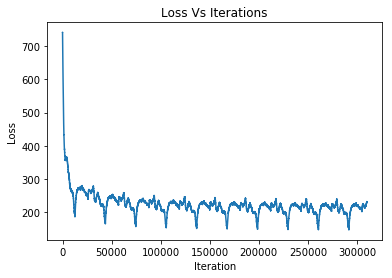

Text generation with the optimal weights when loss is 147.669887169 :

🔅'versedDofirga, they a 'dme &amp; moruial's eakers just great more Acke and loas!
tlect usse and just. Jede concles IFor lob, at tat, missen. He bir llak resIs. I JORT knove. 
"NEieurct hime steal from eloented alsoliber h
You so inpre. It they people to beec croy, Sticthice to blay usso4 Donow and without! Hig sacy, in the mise who retucay dorkert usha quain bi
😬...........Obando that theil #WHOBANIY 4FGATHIFOUSS NO SUS is did!
💯… votiased is."
🐘 #R️ 9 the deco" bebare anew is is nack: The fartert "Amealessed sacht Ittuentioned Rus "Reading the Thank New to to show the big sass, 
htt
‘TexNS RAYs FON dost the curn everin Copure.......... Amego.......
🙌 Jusiter of the fainged have newars medeaued your--"with to cold and 110M, out gefts, many of Ruse celent 1 -- the NE,0 NOW WATOG… httppate 
= Ewed Great 1010 by on Amer!.........
| Are!

In [21]:
# training with Adam as optimizer
weights_Or = InstallWeights(Rnn_Adam)
Weights, Loss = MiniBatchGD(TrumpTweets_1perTime, weights_Or, Rnn_Adam, 'Adam')